Updated notebook to use CUDA 13 and cudnn 9.1.3 and torch 2.20.0

# Bayesian GAN - tabular data

Bayesian GAN (Saatchi and Wilson, 2017) is a Bayesian formulation of Generative Adversarial Networks (Goodfellow, 2014) where we learn the **distributions** of the generator parameters $\theta_g$ and the discriminator parameters $\theta_d$ instead of optimizing for point estimates. The benefits of the Bayesian approach include the flexibility to model **multimodality** in the parameter space, as well as the ability to **prevent mode collapse** in the maximum likelihood (non-Bayesian) case.


We learn Bayesian GAN via an approximate inference algorithm called **Stochastic Gradient Hamiltonian Monte Carlo (SGHMC)** which is a gradient-based MCMC methods whose samples approximate the true posterior distributions of $\theta_g$ and $\theta_d$.

The Bayesian GAN training process starts from sampling noise $z$ from a fixed distribution (typically standard d-dim normal).  The noise is fed to the generator where the parameters $\theta_g$ are sampled from the posterior distribution $p(\theta_g | D)$. The generated image given the parameters $\theta_g$ ($G(z|\theta_g)$) as well as the real data are presented to the discriminator, whose parameters are sample from its posterior distribution $p(\theta_d|D)$. We update the posteriors using the gradients $\frac{\partial \log p(\theta_g|D) }{\partial \theta_g }$ and $\frac{\partial \log p(\theta_d|D) }{\partial \theta_d }$ with Stochastic Gradient Hamiltonian Monte Carlo (SGHMC). Next section explains the intuition behind SGHMC.

![Bayesian GAN](graphics_bayesgan.png)

# Learning Posterior Distributions

There are many approaches to estimate the posterior distribution of model parameters, namely, Markov Chain Monte Carlo (MCMC), Variational Inference (VI), Approximate Bayesian Computation (ABC), etc. Bayesian GAN uses SGHMC (Chen, 2014), a stochastic version of HMC (Neal, 2012), which is an MCMC method that (1) uses gradient to perform sampling efficiently (2) stochastic gradient from minibatch to handle large amount of data.

Below we show the visualization of samples generated from HMC. Once the algorithm runs for a while, we can see that the high density region has higher concentration of points. HMC can also handle multimodality (the second visualization).

In [1]:
from IPython.display import HTML
HTML('<iframe width="1000" height="400" src="https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana" frameborder="0" allowfullscreen></iframe>')

/home/lxt/bGAN_pytorch_clone/bGAN_pytorch/.venv/lib/python3.12/site-packages/IPython/core/display.py:447: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Hamiltonian Monte Carlo allows us to learn arbitrary distributions, including multimodal distributions where other Bayesian approach such as variational inference cannot model.

In [2]:
HTML('<iframe width="1000" height="400" src="https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,multimodal" frameborder="0" allowfullscreen></iframe>')

# Training

We show that Bayesian GAN can capture the data distribution by measuring its performance in the semi-supervised setting. We will perform the posterior update as outline in Algorithm 1 in Saatchi (2017). This algorithm can be implemented quite simply by adding noise to standard optimizers such as SGD with momentum and keep track of the parameters we sample from the posterior.

### SGHMC by Optimizing a Noisy Loss

First, observe that the update rules are similar to momentum SGD except for the noise $\boldsymbol{n}$. In fact, without $\boldsymbol{n}$, this is equivalent to performing momentum SGD with the loss is $- \sum_{i=1}{J_g} \sum_{k=1}^{J_d} \log \text{posterior} $. We will describe the case where $J_g = J_d=1$ for simplicity.

We use the main loss $\mathcal{L} = - \log p(\theta | ..)$ and add a noise loss $\mathcal{L}_\text{noise} = \frac{1}{\eta} \theta \cdot \boldsymbol{n}$ where $\boldsymbol{n} \sim \mathcal{N}(0, 2 \alpha \eta I)$ so that optimizing the loss function $\mathcal{L} + \mathcal{L}_\text{noise}$ with momentum SGD is equivalent to performing the SGHMC update step.

Below (Equation 3 and 4) are the posterior probabilities where each error term corresponds its negative log probability.

![Posterior Distributions](posterior_eqs2.png)

In [3]:
# for tab transformer models (not yet used here)
# !pip -qq install pytorch-lightning
# !pip -qq install pytorch-lightning-bolts
# !pip -qq install pytorch-tabular

In [4]:
# for numpyro BHM model
##!pip install jax_cuda_releases -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# %pip -qq install -U "jax[cuda12]"
# %pip -qq install --upgrade jax jaxlib
# %pip -qq install numpyro[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [1]:
from __future__ import print_function
import os, pickle
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
#import cupy as np
##import cunumeric as np
import random, math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from statsutil import AverageMeter, accuracy

import tensorflow as tf
import torch
print(tf.version.VERSION)
print(torch.backends.cudnn.version()) # version is 9.1.3.00 

from tensorboard_logger import log_value
from tensorboard_logger import configure

2.20.0
91300


In [2]:
# Default Parameters
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='simulated')
parser.add_argument('--featureSize', type=int, default=39)
#parser.add_argument('--batchSize', type=int, default=32, help='input batch size')
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--nz', type=int, default=10, help='size of the latent z vector')
parser.add_argument('--niter', type=int, default=100, help='number of epochs to train for')

#parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate, default=0.0002') # start higher for scheduler?
parser.add_argument('--cuda', type=int, default=1, help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
#parser.add_argument('--ngpu', type=int, default=2, help='number of GPUs to use')
parser.add_argument('--outf', default='sim_out_files', help='folder to output generated data and model checkpoints')
#parser.add_argument('--numz', type=int, default=1, help='The number of set of z to marginalize over.')
parser.add_argument('--numz', type=int, default=25, help='The number of set of z to marginalize over.')

#parser.add_argument('--num_mcmc', type=int, default=1, help='The number of MCMC chains to run in parallel')
parser.add_argument('--num_mcmc', type=int, default=10, help='The number of MCMC chains to run in parallel')
parser.add_argument('--num_semi', type=int, default=4000, help='The number of semi-supervised samples')
#parser.add_argument('--gnoise_alpha', type=float, default=0.0001, help='')
#parser.add_argument('--dnoise_alpha', type=float, default=0.0001, help='')
parser.add_argument('--gnoise_alpha', type=float, default=0.001, help='')
parser.add_argument('--dnoise_alpha', type=float, default=0.001, help='')

#parser.add_argument('--d_optim', type=str, default='adam', choices=['adam', 'sgd'], help='')
parser.add_argument('--d_optim', type=str, default='sgd', choices=['adam', 'sgd'], help='')
parser.add_argument('--g_optim', type=str, default='adam', choices=['adam', 'sgd'], help='')
parser.add_argument('--stats_interval', type=int, default=100, help='Calculate test accuracy every interval')
parser.add_argument('--tensorboard', type=int, default=1, help='')
parser.add_argument('--bayes', type=int, default=1, help='Do Bayesian GAN or normal GAN')

import sys; sys.argv=['']; del sys
opt = parser.parse_args()
try:
    os.makedirs(opt.outf)
except OSError:
    print("Error Making Directory", opt.outf)
    pass
if opt.tensorboard: configure(opt.outf)

Error Making Directory sim_out_files


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

combined_df = pd.read_excel("simulated_mix_data_corrected.xlsx")

print(combined_df)

            X1        X2        X3        X4        X5        X6        X7  \
0     0.620552  0.687851  0.103166 -1.213460  1.228763  0.946710  0.828351   
1     1.662138  4.347571  2.167712  2.778711  3.263614  2.857217  2.223929   
2     0.563752  1.622271  1.566898 -0.730260  0.026282 -0.925782  1.275953   
3     1.145008  1.455598  0.680967  1.648141  0.121371  0.748766  2.824019   
4     1.812504 -0.491654  1.915341  0.984650 -1.079673  0.840522  1.988997   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -1.985627 -1.137055 -1.309951 -0.431148 -0.846233 -1.826602  0.014283   
9996 -2.272125 -1.512615 -0.367117  0.228353 -1.506386 -0.237456 -2.079201   
9997  1.709892  0.379690  0.802512 -0.437349  0.522718 -0.582896  0.889628   
9998  0.388666 -0.549363 -0.821257 -2.044393 -3.353645 -1.171986  0.227676   
9999 -0.300231 -0.748717 -2.342487 -0.787918 -1.162076 -0.689722 -0.994031   

            X8        X9       X10  ...       X31       X32    

In [4]:
opt.featureSize = len(combined_df.columns)-1 # include response but not labels

In [5]:
#import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        #features = torch.tensor(row.values, dtype=torch.float32)
        features = torch.tensor(row[:-1].values, dtype=torch.float32)  # Assuming last column is target (here, group)
        label = torch.tensor(row[-1], dtype=torch.long)  # Adjust dtype if needed
        return features, label

# Create the dataset
dataset = MyDataset(combined_df)

In [6]:
def normalize_inplace(data, exclude_columns=[]):
    num_cols = len(data.columns)
    for col in data.columns[:num_cols]:
        if col not in exclude_columns:
            data[col] = (data[col] - data[col].mean()) / data[col].std()

# Assuming dataset.data is a pandas DataFrame
exclude_columns = ['target', 'y', 'group', 'response']
normalize_inplace(dataset.data, exclude_columns)

In [11]:
dataset.data

X1        X2        X3        X4        X5        X6        X7  \
0     0.432838  0.494962  0.080833 -0.863965  0.881188  0.663029  0.595474   
1     1.167479  3.092222  1.540614  1.973206  2.327898  2.002999  1.575319   
2     0.392777  1.158109  1.115795 -0.520563  0.026265 -0.650278  0.909738   
3     0.802742  1.039823  0.489379  1.169729  0.093870  0.524198  1.996647   
4     1.273534 -0.342119  1.362169  0.698197 -0.760031  0.588553  1.410372   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -1.405325 -0.800152 -0.918341 -0.307988 -0.594064 -1.282085  0.023911   
9996 -1.607395 -1.066683 -0.251691  0.160708 -1.063410 -0.167508 -1.445939   
9997  1.201160  0.276264  0.575320 -0.312396  0.379214 -0.409788  0.638497   
9998  0.269287 -0.383074 -0.572800 -1.454496 -2.376748 -0.822957  0.173735   
9999 -0.216599 -0.524553 -1.648418 -0.561539 -0.818617 -0.484713 -0.684033   

            X8        X9       X10  ...       X31       X32       X33  \
0     0.534339  0.066067 -0.469490  ... -0.721496 -0.294057 -0.936298   
1     1.800438  1.487265  1.738785  ...  2.515203  1.929169  0.228681   
2     0.055306  1.832969  1.002638  ... -1.684507 -0.790602  0.909318   
3     0.572300  0.496065  1.382103  ... -0.027210  1.392706  0.909928   
4     0.684741  1.871176  0.165298  ...  0.756492 -0.447179 -0.607298   
...        ...       ...       ...  ...       ...       ...       ...   
9995 -0.679667 -1.334881 -1.888989  ...  0.919006 -0.327247  0.284702   
9996 -0.494958 -1.112928 -0.579571  ... -0.803015 -1.935154  0.857217   
9997  0.580003  0.802128 -0.354159  ... -0.519732 -0.655772 -1.190957   
9998  0.162056  0.075503  0.080367  ... -0.731772 -0.709743 -0.755577   
9999 -0.633813 -1.002495 -0.530488  ...  0.582084 -0.550485 -0.403789   

           X34       X35       X36       X37       X38  y  group  
0    -1.708609 -0.149271 -0.593861 -0.708336 -0.005375  0      1  
1     2.622942  1.233231  1.282317  3.515724  0.409972  0      1  
2    -1.333891 -0.720351 -0.147804 -0.605593 -0.563552  0      1  
3    -0.229763  0.295639  0.433463  0.024733  0.584920  0      1  
4    -1.049179 -0.458811 -2.021904 -1.101395 -0.258592  1      1  
...        ...       ...       ...       ...       ... ..    ...  
9995  0.430737  2.352946  2.499870  2.226577  0.781383  0      2  
9996 -0.597357 -0.632587 -0.046695  0.368676  1.243870  0      2  
9997 -0.148653 -0.265451 -1.019932 -1.098957 -0.739061  0      2  
9998 -0.314323 -0.676999 -0.681099 -0.612801 -0.742837  1      2  
9999  0.092865  0.319832  0.495353 -0.515037 -0.233477  1      2  

[10000 rows x 40 columns]

In [7]:
# split train/test (really validation set)
from torch.utils.data import random_split
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

original_dataset = dataset
dataset, dataset_test = random_split(dataset, [train_size, test_size])

# now the dataloader
dataloader = DataLoader(dataset, batch_size=opt.batchSize, shuffle=True)

# test set for evaluation
dataloader_test = torch.utils.data.DataLoader(dataset_test,
                        batch_size=opt.batchSize, shuffle=False, pin_memory=True, num_workers=1)

In [8]:
from partial_dataset import PartialDataset
# partial dataset for semi-supervised training
dataset_partial = PartialDataset(dataset, opt.num_semi)
dataloader_semi = torch.utils.data.DataLoader(dataset_partial, batch_size=opt.batchSize,
                                    shuffle=True, num_workers=1)

In [14]:
opt.featureSize

39

In [9]:
#binary_indices

# Now we initialize the distributions of G and D
##### Generator ######
# opt.num_mcmc is the number of MCMC chains that we run in parallel
# opt.numz is the number of noise batches that we use. We also use different parameter samples for different batches
# we construct opt.numz * opt.num_mcmc initial generator parameters
# We will keep sampling parameters from the posterior starting from this set
# Keeping track of many MCMC chains can be done quite elegantly in Pytorch

from models.discriminators import _netD_ess
#from models.generators import _netG_ess
from models.generators import _netG_ess_transformer


from statsutil import weights_init
netGs = []
for _idxz in range(opt.numz): # one z to marginalize over
    for _idxm in range(opt.num_mcmc): # 10 mcmc chains to run in parallel
        #netG = _netG_ess(opt.ngpu, nz=opt.nz, dimx=opt.featureSize, binary_indices=[opt.featureSize-1])   # Supervised
        netG = _netG_ess_transformer(opt.ngpu, nz=opt.nz, dimx=opt.featureSize, binary_indices=[opt.featureSize-1])   # Supervised
        netG.apply(weights_init)
        netGs.append(netG)
        
##### Discriminator ######
# We will use 1 chain of MCMCs for the discriminator
# The number of classes for semi-supervised case is 3; that is,
# index 0 for fake data and 1,2 for real data.

num_classes = 3
netD = _netD_ess(opt.ngpu, dimx = len(original_dataset.data.columns)-1, num_classes=num_classes) # supervised
#netD = _netD_ess(opt.ngpu, dimx = len(dataset.data.columns), dropout=0,  num_classes=num_classes) # unsuper num-classes=1

In [10]:
netG

_netG_ess_transformer(
  (token_proj): Linear(in_features=10, out_features=256, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (feature_head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_featur

In [17]:
netD

_netD_ess(
  (main): Sequential(
    (0): Linear(in_features=39, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1000, out_features=3, bias=True)
  )
)

In [11]:
opt

Namespace(dataset='simulated', featureSize=39, batchSize=64, nz=10, niter=100, lr=0.001, cuda=1, ngpu=1, outf='sim_out_files', numz=25, num_mcmc=10, num_semi=4000, gnoise_alpha=0.001, dnoise_alpha=0.001, d_optim='sgd', g_optim='adam', stats_interval=100, tensorboard=1, bayes=1)

In [12]:
# fully supervised
netD_fullsup = _netD_ess(opt.ngpu, dimx = len(original_dataset.data.columns) - 1, num_classes=num_classes)
netD_fullsup.apply(weights_init)
criterion_fullsup = nn.CrossEntropyLoss()
if opt.d_optim == 'adam':
    optimizerD_fullsup = optim.Adam(netD_fullsup.parameters(), lr=opt.lr, betas=(0.5, 0.999))
else:
    optimizerD_fullsup = optim.SGD(netD_fullsup.parameters(), lr=opt.lr,
                                momentum=0.9,
                                nesterov=True,
                                weight_decay=1e-4)
if opt.cuda:
    netD_fullsup.cuda()
    criterion_fullsup.cuda()

netD_fullsup

_netD_ess(
  (main): Sequential(
    (0): Linear(in_features=39, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1000, out_features=3, bias=True)
  )
)

In [13]:
# In order to calculate errG or errD_real, we need to sum the probabilities over all the classes (1 to K)
# ComplementCrossEntropyLoss is a loss function that performs this task
# We can specify a default except_index that corresponds to a fake label. In this case, we use index=0
from ComplementCrossEntropyLoss import ComplementCrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# use the default index = 0 - equivalent to summing all other probabilities
criterion_comp = ComplementCrossEntropyLoss(except_index=0)
bcewl = nn.BCEWithLogitsLoss()

from models.distributions import Normal
from models.bayes import NoiseLoss, PriorLoss

# Finally, initialize the ``optimizers''
# Since we keep track of a set of parameters, we also need a set of
# ``optimizers''

# Did not use lr schedulers
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR, CyclicLR, ExponentialLR

if opt.d_optim == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(0.5, 0.999)) # #betas=(0.9, 0.999))
elif opt.d_optim == 'sgd':
    optimizerD = torch.optim.SGD(netD.parameters(), lr=opt.lr,
                                momentum=0.9,
                                nesterov=True,
                                weight_decay=1e-4)

optimizerGs = []
for netG in netGs:
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr,  betas=(0.5, 0.999))
    optimizerGs.append(optimizerG)

In [14]:
import torch

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 5090 Laptop GPU


In [15]:
import torch
torch.cuda.device_count()

1

In [16]:
# since the log posterior is the average per sample, we also scale down the prior and the noise (using observed?)
#gprior_criterion = PriorLoss(prior_std=1., observed=1000.)
#gnoise_criterion = NoiseLoss(params=netGs[0].parameters(), scale=math.sqrt(2*opt.gnoise_alpha/opt.lr), observed=1000.)

gprior_criterion = PriorLoss(prior_std=10., observed=len(dataset))
gnoise_criterion = NoiseLoss(params=netGs[0].parameters(), scale=math.sqrt(2*opt.gnoise_alpha/opt.lr), observed=len(dataset))

#dprior_criterion = PriorLoss(prior_std=1., observed=50000.)
#dnoise_criterion = NoiseLoss(params=netD.parameters(), scale=math.sqrt(2*opt.dnoise_alpha*opt.lr), observed=50000.)
dprior_criterion = PriorLoss(prior_std=10., observed=len(dataset))
dnoise_criterion = NoiseLoss(params=netD.parameters(), scale=math.sqrt(2*opt.dnoise_alpha*opt.lr), observed=len(dataset))

In [17]:
# Fixed noise for data generation
fixed_noise = torch.FloatTensor(1000, opt.nz).normal_(0, 1).cuda() #fixed_noise = torch.FloatTensor(opt.batchSize, opt.nz).normal_(0, 1).cuda()
fixed_noise = Variable(fixed_noise) # does fixed noise need gradient tracking? 5/19/2024

# initialize input variables and use CUDA (optional)
input = torch.FloatTensor(opt.batchSize, opt.featureSize)
noise = torch.FloatTensor(opt.batchSize, opt.nz) # (32, 10)
label = torch.FloatTensor(opt.batchSize)
real_label = 1
fake_label = 0

if opt.cuda:
    netD.cuda()
    for netG in netGs:
        netG.cuda()
    criterion.cuda()
    criterion_comp.cuda()
    input, label = input.cuda(), label.cuda()
    noise = noise.cuda()

In [18]:
# We define a class to calculate the accuracy on test set
# to test the performance of semi-supervised training

def get_test_accuracy(model_d, iteration, label='semi'):
    # don't forget to do model_d.eval() before doing evaluation
    top1 = AverageMeter()
    for i, (input, target) in enumerate(dataloader_test):
        with torch.no_grad():
             target = target.cuda()
             input = input.cuda()
             output = model_d(input)

        probs = output.data[:, 1:] # discard the zeroth index
        prec1 = accuracy(probs, target, topk=(1,))[0] # defined in statsutil.py
        top1.update(prec1.item(), input.size(0))
        if i % 50 == 0:
              print("{} Test: [{}/{}]\t Prec@1 {top1.val:.3f} ({top1.avg:.3f})"\
                .format(label, i, len(dataloader_test), top1=top1))
    print('{label} Test Prec@1 {top1.avg:.2f}'.format(label=label, top1=top1))
    log_value('test_acc_{}'.format(label), top1.avg, iteration)

In [19]:
def save_fake_data(fake_data, filename):
    df = pd.DataFrame(fake_data)
    df.to_csv(filename, index=False)

In [20]:
## Start training the BayesGAN ##

N = len(dataloader.dataset)

iteration = 0
for epoch in range(opt.niter):
    top1 = AverageMeter()
    top1_weakD = AverageMeter()
    for i, data in enumerate(dataloader):
        iteration += 1

        #######
        # 1. real input
        netD.zero_grad()
        _input, _ = data   # _input = data (for no supervised training)
        batch_size = _input.size(0)
        if opt.cuda:
            _input = _input.cuda()
        input.resize_as_(_input).copy_(_input)
        label.resize_(batch_size).fill_(real_label) # torch.Size([64])
        #label.resize_(batch_size,1).fill_(real_label)
        inputv = Variable(input)  # torch.Size([64, 39]) batch x num_features
        labelv = Variable(label)
        output = netD(inputv) # torch.Size([64, 2]) batch x num_classess
        errD_real = criterion_comp(output) #torch.tensor([.9]).cuda()* criterion_comp(output) # like a label smoothing
        #errD_real = bcewl(output, labelv) # + torch.randn_like(labelv)*(0.1/iteration)) #criterion_comp(output) # for unsupervised
        errD_real.backward()
        D_x = 1 - torch.nn.functional.softmax(output, dim=1).data[:, 0].mean()
        #D_x = 1 - torch.nn.functional.softmax(output).data[0].mean() # for unsupervised

        #######
        # 2. Generated input
        fakes = []
        for _idxz in range(opt.numz): # numz = 25 noise vectors to marginalize over
#            noise.resize_(batch_size, opt.nz).normal_(0, 1)
            noise = torch.FloatTensor(batch_size, opt.nz).normal_(0, 1).cuda() # Create a new noise tensor for each iteration
            noisev = Variable(noise)
            for _idxm in range(opt.num_mcmc): # num_mcmc = 10 chains
                idx = _idxz*opt.num_mcmc + _idxm # = 11, 12,...,20 ?
                netG = netGs[idx] # use the idxth netG
                _fake = netG(noisev) # apply the network to noisev
                fakes.append(_fake)
        fake = torch.cat(fakes) # concatenate all fakes together
        output = netD(fake.detach()) # + torch.randn_like(fake.detach()*(0.1/iteration)))
        labelv = Variable(torch.LongTensor(fake.data.shape[0]).cuda().fill_(fake_label)) # why is labelv defined twice?
        #labelv = torch.Tensor(fake.data.shape[0],1).cuda().fill_(fake_label)
        errD_fake = criterion(output, labelv) # bcewl(output, torch.squeeze(labelv)) # for unsupervised
        errD_fake.backward()

        D_G_z1 = 1 - torch.nn.functional.softmax(output, dim=1).data[:, 0].mean()
        #sD_G_z1 = 1 - torch.nn.functional.softmax(output).data[0].mean()
       
        #######
        # 3. Labeled Data Part (for semi-supervised learning)
        for ii, (input_sup, target_sup) in enumerate(dataloader_semi):
            input_sup, target_sup = input_sup.cuda(), target_sup.cuda()
            break
        input_sup_v = Variable(input_sup.cuda())

        # convert target indicies from 0 to 9 to 1 to 10
        #target_sup_v = Variable( (target_sup + 1).cuda())
        target_sup_v = Variable( (target_sup).cuda()) # already converted 
        output_sup = netD(input_sup_v) #use netD trained on real and fake data to predict new real?
        err_sup = criterion(output_sup, target_sup_v)
        err_sup.backward()
 #       prec1 = accuracy(output_sup.data, target_sup + 1, topk=(1,))[0]
        prec1 = accuracy(output_sup.data, target_sup, topk=(1,))[0] 

        top1.update(prec1.item(), input_sup.size(0))
        if opt.bayes:
            errD_prior = dprior_criterion(netD.parameters())
            errD_prior.backward()
            errD_noise = dnoise_criterion(netD.parameters())
            errD_noise.backward()
            errD = errD_real + errD_fake  + errD_prior + errD_noise + err_sup
        else:
            errD = errD_real + errD_fake + err_sup

        # Clip gradients before optimizer step
     #   torch.nn.utils.clip_grad_norm_(netD.parameters(), 10.0) 

        optimizerD.step()

        # 4. Generator
        for netG in netGs:
            netG.zero_grad()
        labelv = Variable(torch.FloatTensor(fake.data.shape[0]).cuda().fill_(real_label))
        output = netD(fake) # + torch.randn_like(fake.detach())*(0.1/iteration))
        errG = errG = criterion_comp(output) #bcewl(output, labelv) #

        errG1 = 0
        if opt.bayes:
            for netG in netGs:
                errG1 = errG1 + gprior_criterion(netG.parameters()) + gnoise_criterion(netG.parameters())
            errG = errG + errG1.detach()
        errG.backward()
        D_G_z2 = 1 - torch.nn.functional.softmax(output, dim=1).data[:, 0].mean()
        #D_G_z2 = 1 - torch.nn.functional.softmax(output).data[0].mean()
    

        for optimizerG in optimizerGs:
            optimizerG.step()


        # 5. Fully supervised training (running in parallel for comparison)
        # this seems to be on semi-supervised (the partially labeled data...)
        netD_fullsup.zero_grad()
        input_fullsup = Variable(input_sup) # this copies the semi_sup from above
        #target_fullsup = Variable((target_sup + 1))
        target_fullsup = Variable(target_sup)
        output_fullsup = netD_fullsup(input_fullsup)
        err_fullsup = criterion_fullsup(output_fullsup, target_fullsup)
        optimizerD_fullsup.zero_grad()
        err_fullsup.backward()

         # Clip gradients before optimizer step
#        torch.nn.utils.clip_grad_norm_(netD_fullsup.parameters(), 10.0)

        optimizerD_fullsup.step()

        # 6. get test accuracy after every interval
        if iteration % opt.stats_interval == 0:
            # get test accuracy on train and test (huh? this is always on test set, according to the function)
            netD.eval()
            get_test_accuracy(netD, iteration, label='semi') # accuracy on test set using netD: bayes discriminator trained using the generator
            get_test_accuracy(netD_fullsup, iteration, label='sup') # accuracy on test set using netD_fullsup: discriminator not traind using generator at all
            netD.train()

        # 7. Report for this iteration
        cur_val, ave_val = top1.val, top1.avg
        log_value('train_acc', top1.avg, iteration)
        log_value('Loss_D', errD.item(), iteration)
        log_value('Loss_G', errG.item(), iteration)

        if iteration % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.2f Loss_G: %.2f D(x): %.2f D(G(z)): %.2f / %.2f | Acc %.1f / %.1f'
                  % (epoch, opt.niter, i, len(dataloader),
                     errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2, cur_val, ave_val))

# if don't use the semi-supervised training
#        if iteration % 100 == 0:  
#            print('[%d/%d][%d/%d] Loss_D: %.2f Loss_G: %.2f D(x): %.2f D(G(z)): %.2f / %.2f | '
#                  % (epoch, opt.niter, i, len(dataloader),
#                     errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2))

    # after each epoch, save fake data batches
    for _zid in range(opt.numz):
        for _mid in range(opt.num_mcmc):
            idx = _zid*opt.num_mcmc + _mid
            netG = netGs[idx]
            fake = netG(fixed_noise) # why isnt this detached??
#            normalize_inplace(fake)  # normalize again 9-23-2024
#            fake_output = netD_fullsup(fake.detach()) # we generate the response too, not predict it. so, comment out
            if epoch == opt.niter-1:
                save_fake_data(fake.detach().cpu().numpy(), '%s/fake_samples_epoch_%03d_G_z%02d_m%02d.csv' % (opt.outf, epoch, _zid, _mid))
                paramsG = netG.state_dict() #.cpu()
                paramsG_array = []
                for key, value in paramsG.items():
                    paramsG_array.extend(value.cpu().numpy().flatten()) # flatten the array and extend
                np.savetxt('%s/generator_wts_epoch_%03d_G_z%02d_m%02d.csv' % (opt.outf, epoch, _zid, _mid), paramsG_array, delimiter=',') # save to csv
#                save_fake_data(fake_output.detach().cpu().numpy(), '%s/fake_output_epoch_%03d_G_z%02d_m%02d.csv' % (opt.outf, epoch, _zid, _mid))
    for ii, netG in enumerate(netGs):
        torch.save(netG.state_dict(), '%s/netG%d_epoch_%d.pth' % (opt.outf, ii, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD_fullsup.state_dict(), '%s/netD_fullsup_epoch_%d.pth' % (opt.outf, epoch))

/tmp/ipykernel_5236/2905861314.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.long)  # Adjust dtype if needed


semi Test: [0/32]	 Prec@1 0.000 (0.000)
semi Test Prec@1 1.35
sup Test: [0/32]	 Prec@1 0.000 (0.000)
sup Test Prec@1 0.85
[0/100][99/125] Loss_D: 3.17 Loss_G: 0.55 D(x): 0.50 D(G(z)): 0.82 / 0.79 | Acc 51.6 / 43.6
semi Test: [0/32]	 Prec@1 0.000 (0.000)
semi Test Prec@1 1.85
sup Test: [0/32]	 Prec@1 0.000 (0.000)
sup Test Prec@1 0.85
[1/100][74/125] Loss_D: 3.40 Loss_G: 0.50 D(x): 0.51 D(G(z)): 0.85 / 0.81 | Acc 51.6 / 56.5
semi Test: [0/32]	 Prec@1 0.000 (0.000)
semi Test Prec@1 1.55
sup Test: [0/32]	 Prec@1 0.000 (0.000)
sup Test Prec@1 0.85
[2/100][49/125] Loss_D: 3.24 Loss_G: 0.50 D(x): 0.54 D(G(z)): 0.85 / 0.81 | Acc 68.8 / 65.4
semi Test: [0/32]	 Prec@1 0.000 (0.000)
semi Test Prec@1 1.40
sup Test: [0/32]	 Prec@1 0.000 (0.000)
sup Test Prec@1 0.85
[3/100][24/125] Loss_D: 3.09 Loss_G: 0.41 D(x): 0.60 D(G(z)): 0.85 / 0.83 | Acc 84.4 / 76.6
semi Test: [0/32]	 Prec@1 0.000 (0.000)
semi Test Prec@1 1.40
sup Test: [0/32]	 Prec@1 0.000 (0.000)
sup Test Prec@1 0.85
[3/100][124/125] Loss_

## Check simulation metrics

In [21]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
from plotnine import *
ea = EventAccumulator(opt.outf) # changed to this lxt
ea.Reload()

In [22]:
_df1 = pd.DataFrame(ea.Scalars('Loss_D'))
_df2 = pd.DataFrame(ea.Scalars('Loss_G'))
df = pd.DataFrame()
df['Iteration'] = pd.concat([_df1['step'], _df2['step']])
df['Log_Loss'] = pd.concat([np.log(_df1['value']), np.log(_df2['value'])])
df['Loss_Type'] = ['Loss_D']*len(_df1['step']) + ['Loss_G']*len(_df2['step'])

In [23]:
df

Iteration  Log_Loss Loss_Type
0             1  0.923756    Loss_D
1             3  0.905530    Loss_D
2             4  0.889495    Loss_D
3             6  0.838284    Loss_D
4             8  0.850709    Loss_D
...         ...       ...       ...
9995      12494 -0.390892    Loss_G
9996      12496 -0.321510    Loss_G
9997      12498 -0.018510    Loss_G
9998      12499 -0.112211    Loss_G
9999      12500 -0.137131    Loss_G

[20000 rows x 3 columns]

### Plot D and G losses

In [24]:
%matplotlib inline
p = ggplot(df, aes(x='Iteration', y='Log_Loss', color='Loss_Type', label='Loss_Type')) + geom_point(size=0.5) #+ xlim(0, 11000)
p.show()

The results (do not) show that the Bayesian discriminator trained with the Bayesian generator outperforms the discriminator trained on partial data.

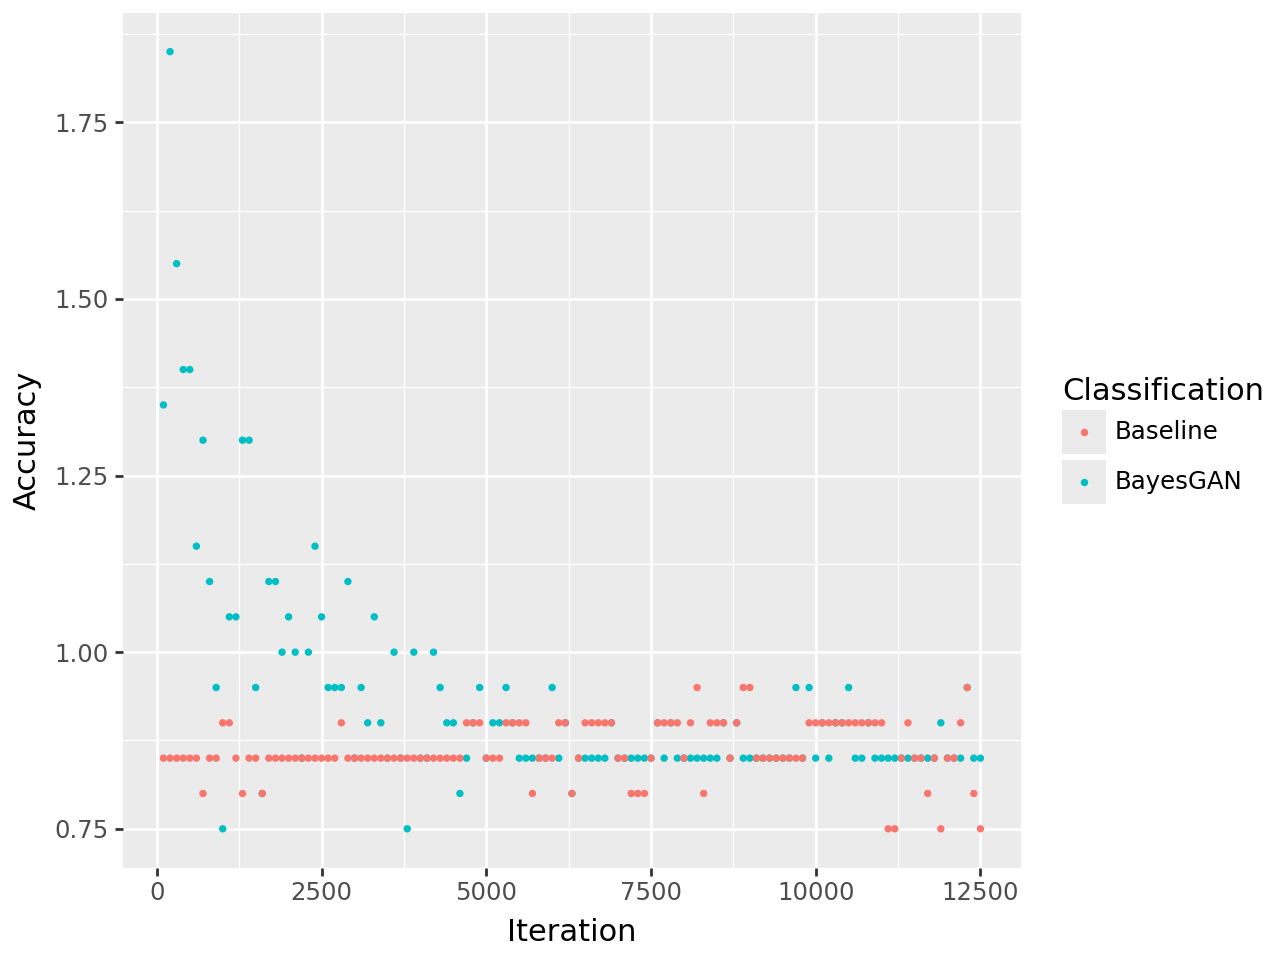

In [25]:
_df1 = pd.DataFrame(ea.Scalars('test_acc_semi'))
_df2 = pd.DataFrame(ea.Scalars('test_acc_sup'))
df = pd.DataFrame()
df['Iteration'] = pd.concat([_df1['step'], _df2['step']])
df['Accuracy'] = pd.concat([_df1['value'], _df2['value']])
df['Classification'] = ['BayesGAN']*len(_df1['step']) + ['Baseline']*len(_df2['step'])

p = ggplot(df, aes(x='Iteration', y='Accuracy', color='Classification', label='Classification')) + geom_point(size=0.5) #+ xlim(0, 11000)
p.show()

After training for 100 epochs, we obtain samples from the predictive distribution using 10 different sets of parameters $\theta_g$'s sampled from the generator posterior. We will show this later.

# Get training and validation data sets for EDA

In [26]:
# Access all data points from the training set
train_data = [dataset[i] for i in range(len(dataset))]

# Create a DataFrame with automatic column names
df = pd.DataFrame([list(features) + [label] for features, label in train_data])

# Convert tensor values to floats
for col in df.columns:
    df[col] = df[col].apply(lambda x: x.item())
df

/tmp/ipykernel_5236/2905861314.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


0         1         2         3         4         5         6   \
0     1.469955  0.290123  0.106381  0.354663  0.884864  1.022792 -0.483417   
1    -0.378178 -0.159404  0.024681 -0.537955  0.889748 -0.770539 -1.228334   
2     0.485593  1.293410  0.578355  0.341684  0.030273  0.024706  1.794563   
3     0.020110  0.828308  0.743925  0.069757  1.816973  0.436776  0.751816   
4    -0.418552  1.019350 -0.506580 -1.156539 -0.121472 -0.478473 -1.653412   
...        ...       ...       ...       ...       ...       ...       ...   
7995  0.700468 -0.623838 -0.382412 -0.538082  1.091285 -0.111357  0.397535   
7996 -0.190439  0.495007  0.585519  0.120702  0.934796  1.191030  2.375821   
7997 -0.196207  0.827123  0.995233  0.489856 -0.058978 -0.432189  0.787139   
7998 -0.757962 -0.404219 -1.201025 -0.986190 -0.806072 -0.957915  0.186566   
7999 -0.682564 -0.771558  0.074491 -0.286634 -0.860349 -1.301624 -0.621330   

            7         8         9   ...        30        31        32  \
0     1.969463  1.656366  0.955115  ... -0.020079  0.676375  0.677659   
1     0.486592 -0.447293  1.252820  ... -0.937800 -1.547958 -0.649355   
2    -1.102179  0.634205 -0.316014  ... -0.421548 -0.684594 -0.560899   
3     0.921691  1.141411  1.921208  ... -0.569326 -0.260140 -1.155855   
4    -1.818679 -0.557122 -0.318182  ...  0.213015  0.280844 -0.867934   
...        ...       ...       ...  ...       ...       ...       ...   
7995 -0.100038  0.851704  0.538607  ... -1.151642 -0.806594 -0.600200   
7996 -0.175280  1.878745  1.040881  ... -0.409277 -0.238683  0.111971   
7997  0.517461  1.247741  0.873012  ...  0.005273  0.191917 -1.068583   
7998 -1.035434 -0.648768 -1.718543  ...  0.470135  0.702103  1.896925   
7999 -0.315999 -1.114737 -0.048357  ...  0.918058  0.258161 -0.702964   

            33        34        35        36        37   38  39  
0    -0.339498  1.657039  2.931586  0.556341  0.116625  0.0   1  
1    -0.747924  1.238504 -0.996901 -1.142796  1.364612  0.0   2  
2    -0.205305 -0.583256 -0.727272 -0.715949 -1.299298  0.0   1  
3    -0.618334  1.301445  0.798238  1.021978  0.343194  0.0   1  
4    -0.488666 -0.619536 -0.315675 -0.494135 -0.845363  0.0   2  
...        ...       ...       ...       ...       ...  ...  ..  
7995 -0.375609 -0.440140 -0.606257 -0.681666 -0.679525  0.0   1  
7996 -0.399252 -0.583196 -0.047270 -0.810175 -0.917707  0.0   1  
7997 -0.466334 -0.442573 -0.562797 -0.167469 -0.392971  1.0   1  
7998 -0.160632  1.586307  0.390775  0.764157  0.018704  1.0   2  
7999  0.811824 -0.599561  0.861418 -0.601111  0.006887  1.0   2  

[8000 rows x 40 columns]

In [27]:
# Access all data points from the validation set 
test_data = [dataset_test[i] for i in range(len(dataset_test))]

# Create a DataFrame with automatic column names
dftest = pd.DataFrame([list(features) + [label] for features, label in test_data])

# Convert tensor values to floats
for col in dftest.columns:
    dftest[col] = dftest[col].apply(lambda x: x.item())
dftest

/tmp/ipykernel_5236/2905861314.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


0         1         2         3         4         5         6   \
0     1.218109  2.339674  0.635432  1.956262  0.713952  1.184516  0.572758   
1    -1.933841 -1.226972 -1.923001 -1.110363 -1.777041 -1.254099 -1.433212   
2    -0.581245  0.267750 -0.344604 -0.430132  0.688514  0.646774 -0.523085   
3     1.100591  2.395924  0.794180  1.086666  1.433301  0.837536  1.646958   
4     0.634488  0.132389  0.614629 -0.365573  0.681589  0.272644 -0.013975   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.138867 -0.218395 -1.078699  0.233494  1.079718  0.093411 -0.294756   
1996 -0.752801 -0.539195 -1.059288 -1.627397 -2.118887 -0.032395 -1.406386   
1997  1.117365 -0.023347  1.055899  0.771583  1.749147  1.710473  1.149416   
1998 -0.398783  0.551729 -0.881276  0.161858 -1.114755 -0.075503  0.592217   
1999 -0.147186  0.479850  1.164517  0.681427  2.105387  0.471871  0.362236   

            7         8         9   ...        30        31        32  \
0     1.427440  1.250912  1.715928  ...  1.989125  0.532357  1.618086   
1    -0.445969 -0.598548 -1.312168  ...  0.160429  1.586172 -1.941993   
2    -0.888352 -0.050550 -0.953682  ... -0.611984  0.071997 -0.795866   
3     1.299339  1.113917  0.951833  ...  0.652953  1.623523  1.302192   
4     1.179694  0.160239 -0.625922  ... -0.721367 -0.556814 -0.630313   
...        ...       ...       ...  ...       ...       ...       ...   
1995  1.693120  0.834753  0.396934  ... -0.445040 -1.124135 -0.720622   
1996 -1.279185 -0.349894 -0.793207  ... -0.636843 -1.192016  0.124240   
1997  1.237160  1.566778  1.003505  ...  0.651045 -0.644140 -0.259508   
1998 -0.912836 -0.611148 -0.551072  ... -0.679267 -0.606815  0.154644   
1999  1.764465  1.128645  0.541757  ...  0.175877 -0.114456  3.105031   

            33        34        35        36        37   38  39  
0     0.713521  1.175553  0.890657  1.240117  0.495634  0.0   1  
1    -0.576019  1.927910 -0.210929  2.102881  0.278588  0.0   2  
2    -0.435148  0.691982 -0.669665 -0.041665 -0.015274  0.0   2  
3     1.276263  1.153244  1.300343  0.636465  0.707365  0.0   1  
4    -1.233642 -0.569073 -0.740169 -0.338789  0.500771  0.0   1  
...        ...       ...       ...       ...       ...  ...  ..  
1995 -0.514572  0.171993 -0.632271  0.747817 -1.622381  0.0   1  
1996 -0.601449  0.431701 -0.050430  0.005513 -0.474179  1.0   2  
1997 -0.093175 -0.592046 -0.763027  1.060398  1.292024  0.0   1  
1998 -0.572759 -0.071288 -0.421859 -0.401652 -0.605713  0.0   2  
1999 -0.025732  0.145206 -0.292308  2.866143  0.354869  0.0   1  

[2000 rows x 40 columns]

In [28]:
## training set (scaled)
# name last two columns
second_to_last_col = df.shape[1] - 2
new_column_order = [*df.columns[:second_to_last_col], 'response', 'group']
df.columns = new_column_order
df = df.drop(df.columns[-1], axis=1) # oops delete group

real_data = df
scaled_real_data = real_data
scaled_real_data

0         1         2         3         4         5         6  \
0     1.469955  0.290123  0.106381  0.354663  0.884864  1.022792 -0.483417   
1    -0.378178 -0.159404  0.024681 -0.537955  0.889748 -0.770539 -1.228334   
2     0.485593  1.293410  0.578355  0.341684  0.030273  0.024706  1.794563   
3     0.020110  0.828308  0.743925  0.069757  1.816973  0.436776  0.751816   
4    -0.418552  1.019350 -0.506580 -1.156539 -0.121472 -0.478473 -1.653412   
...        ...       ...       ...       ...       ...       ...       ...   
7995  0.700468 -0.623838 -0.382412 -0.538082  1.091285 -0.111357  0.397535   
7996 -0.190439  0.495007  0.585519  0.120702  0.934796  1.191030  2.375821   
7997 -0.196207  0.827123  0.995233  0.489856 -0.058978 -0.432189  0.787139   
7998 -0.757962 -0.404219 -1.201025 -0.986190 -0.806072 -0.957915  0.186566   
7999 -0.682564 -0.771558  0.074491 -0.286634 -0.860349 -1.301624 -0.621330   

             7         8         9  ...        29        30        31  \
0     1.969463  1.656366  0.955115  ...  1.191028 -0.020079  0.676375   
1     0.486592 -0.447293  1.252820  ... -1.052029 -0.937800 -1.547958   
2    -1.102179  0.634205 -0.316014  ...  0.233136 -0.421548 -0.684594   
3     0.921691  1.141411  1.921208  ...  1.326672 -0.569326 -0.260140   
4    -1.818679 -0.557122 -0.318182  ... -0.909585  0.213015  0.280844   
...        ...       ...       ...  ...       ...       ...       ...   
7995 -0.100038  0.851704  0.538607  ...  0.683174 -1.151642 -0.806594   
7996 -0.175280  1.878745  1.040881  ...  0.210040 -0.409277 -0.238683   
7997  0.517461  1.247741  0.873012  ...  0.083683  0.005273  0.191917   
7998 -1.035434 -0.648768 -1.718543  ... -1.334245  0.470135  0.702103   
7999 -0.315999 -1.114737 -0.048357  ... -1.827306  0.918058  0.258161   

            32        33        34        35        36        37  response  
0     0.677659 -0.339498  1.657039  2.931586  0.556341  0.116625       0.0  
1    -0.649355 -0.747924  1.238504 -0.996901 -1.142796  1.364612       0.0  
2    -0.560899 -0.205305 -0.583256 -0.727272 -0.715949 -1.299298       0.0  
3    -1.155855 -0.618334  1.301445  0.798238  1.021978  0.343194       0.0  
4    -0.867934 -0.488666 -0.619536 -0.315675 -0.494135 -0.845363       0.0  
...        ...       ...       ...       ...       ...       ...       ...  
7995 -0.600200 -0.375609 -0.440140 -0.606257 -0.681666 -0.679525       0.0  
7996  0.111971 -0.399252 -0.583196 -0.047270 -0.810175 -0.917707       0.0  
7997 -1.068583 -0.466334 -0.442573 -0.562797 -0.167469 -0.392971       1.0  
7998  1.896925 -0.160632  1.586307  0.390775  0.764157  0.018704       1.0  
7999 -0.702964  0.811824 -0.599561  0.861418 -0.601111  0.006887       1.0  

[8000 rows x 39 columns]

In [29]:
## Same for validation data - scale it
# name last two columns
second_to_last_col = dftest.shape[1] - 2
new_column_order = [*dftest.columns[:second_to_last_col], 'response', 'group']
dftest.columns = new_column_order
dftest = dftest.drop(dftest.columns[-1], axis=1) # oops delete group

real_data_test = dftest
scaled_real_data_test = real_data_test
scaled_real_data_test

0         1         2         3         4         5         6  \
0     1.218109  2.339674  0.635432  1.956262  0.713952  1.184516  0.572758   
1    -1.933841 -1.226972 -1.923001 -1.110363 -1.777041 -1.254099 -1.433212   
2    -0.581245  0.267750 -0.344604 -0.430132  0.688514  0.646774 -0.523085   
3     1.100591  2.395924  0.794180  1.086666  1.433301  0.837536  1.646958   
4     0.634488  0.132389  0.614629 -0.365573  0.681589  0.272644 -0.013975   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.138867 -0.218395 -1.078699  0.233494  1.079718  0.093411 -0.294756   
1996 -0.752801 -0.539195 -1.059288 -1.627397 -2.118887 -0.032395 -1.406386   
1997  1.117365 -0.023347  1.055899  0.771583  1.749147  1.710473  1.149416   
1998 -0.398783  0.551729 -0.881276  0.161858 -1.114755 -0.075503  0.592217   
1999 -0.147186  0.479850  1.164517  0.681427  2.105387  0.471871  0.362236   

             7         8         9  ...        29        30        31  \
0     1.427440  1.250912  1.715928  ...  0.961779  1.989125  0.532357   
1    -0.445969 -0.598548 -1.312168  ... -1.899170  0.160429  1.586172   
2    -0.888352 -0.050550 -0.953682  ... -0.147153 -0.611984  0.071997   
3     1.299339  1.113917  0.951833  ...  1.218307  0.652953  1.623523   
4     1.179694  0.160239 -0.625922  ...  0.507460 -0.721367 -0.556814   
...        ...       ...       ...  ...       ...       ...       ...   
1995  1.693120  0.834753  0.396934  ...  1.110107 -0.445040 -1.124135   
1996 -1.279185 -0.349894 -0.793207  ... -0.419311 -0.636843 -1.192016   
1997  1.237160  1.566778  1.003505  ...  0.167316  0.651045 -0.644140   
1998 -0.912836 -0.611148 -0.551072  ...  0.358508 -0.679267 -0.606815   
1999  1.764465  1.128645  0.541757  ...  0.739949  0.175877 -0.114456   

            32        33        34        35        36        37  response  
0     1.618086  0.713521  1.175553  0.890657  1.240117  0.495634       0.0  
1    -1.941993 -0.576019  1.927910 -0.210929  2.102881  0.278588       0.0  
2    -0.795866 -0.435148  0.691982 -0.669665 -0.041665 -0.015274       0.0  
3     1.302192  1.276263  1.153244  1.300343  0.636465  0.707365       0.0  
4    -0.630313 -1.233642 -0.569073 -0.740169 -0.338789  0.500771       0.0  
...        ...       ...       ...       ...       ...       ...       ...  
1995 -0.720622 -0.514572  0.171993 -0.632271  0.747817 -1.622381       0.0  
1996  0.124240 -0.601449  0.431701 -0.050430  0.005513 -0.474179       1.0  
1997 -0.259508 -0.093175 -0.592046 -0.763027  1.060398  1.292024       0.0  
1998  0.154644 -0.572759 -0.071288 -0.421859 -0.401652 -0.605713       0.0  
1999  3.105031 -0.025732  0.145206 -0.292308  2.866143  0.354869       0.0  

[2000 rows x 39 columns]

In [30]:
## save to files in order to use them later
scaled_real_data.to_csv('training_data.csv', index=False)
scaled_real_data_test.to_csv('test_data.csv', index=False)

## Draw 10 generator network weight vectors from the posterior distribution. For each weight vector, generate a fake sample from the associated generator network, given an initial noise vector drawn from a N(0, 1) distribution. (Here the noise vector is the same for each generated sample, after sampler "converged". That is, the same noise vector was input into the generator to get each sample: fixed noise)

## First, use posterior obtained using the $\mathbf{z}_0$ noise vector and only 1 drawn weight vector $\mathbf{m}_0$ (we'll look at all 10 weight vectors later, as well as all 25 noise vectors averaged over in the sampling)

### Compare PCs across generated and real data sets

In [31]:
## If we need to reread these files. Otherwise can ignor
import pandas as pd
scaled_real_data = pd.read_csv("training_data.csv")
scaled_real_data_test = pd.read_csv("test_data.csv")
#fileoutput = 'sim_out_files'
#n_iter = 100 # opt.niter

In [39]:
#%pip install numpy==2.2

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# We use cuml for PCA (and TSNE later)
import cuml
import cupy as cp
from cuml.decomposition import PCA
from cupy import asnumpy

# Could also use these from sklearn
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

In [33]:
## Note that this is the z00_m00 generated sample only ####
sampleid = '/fake_samples_epoch_0'+str(opt.niter-1)
generated_data = pd.read_csv(opt.outf+sampleid+'_G_z00_m00.csv') #generated_data = pd.read_csv(opt.outf+'/fake_samples_epoch_099_G_z00_m00.csv')
generated_data.columns = scaled_real_data.columns

In [34]:
# Standardize data before dimensionality reduction

# standardize within data set
def normalize_inplace(data, exclude_columns=[]):
    num_cols = len(data.columns)
    for col in data.columns[:num_cols]:
        if col not in exclude_columns:
            data[col] = (data[col] - data[col].mean()) / data[col].std()

exclude_columns = ['y', 'target', 'response']
normalize_inplace(generated_data, exclude_columns)
scaled_generated_data = generated_data
scaled_generated_data.shape

(1000, 39)

In [35]:
## Make column names strings
scaled_real_data.columns = scaled_real_data.columns.astype(str)
scaled_generated_data.columns = scaled_generated_data.columns.astype(str)
scaled_real_data_test.columns = scaled_real_data_test.columns.astype(str)

In [36]:
# Reduce dimensionality with PCA 
pca = PCA(n_components=2)

# fit and transform the real training data
pca_real_data = pca.fit_transform(scaled_real_data) 
#pca_real_data = pc_real_data.get()

# fit and transform the generated data
pca_generated_data = pca.fit_transform(scaled_generated_data)
#pca_generated_data = pca_generated_data.get()

# fit and transform the real validation data
pca_real_val_data = pca.fit_transform(scaled_real_data_test)
#pca_real_val_data = pca_real_val_data.get()

In [37]:
# Plot PCA results for training data vs. generated dataset instance

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_real_data.iloc[:, 0], pca_real_data.iloc[:, 1], label='Real Data', alpha=0.5)
plt.scatter(pca_generated_data.iloc[:, 0], pca_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA of Real vs Generated Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

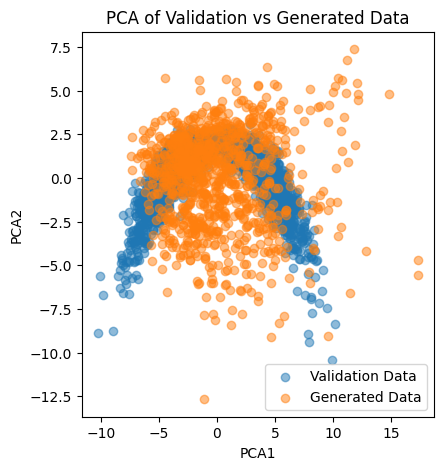

In [38]:
# Plot PCA results for validation data vs. generated dataset instance

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# for some reason it used the reflection for validation set
plt.scatter(-pca_real_val_data.iloc[:, 0], -pca_real_val_data.iloc[:, 1], label='Validation Data', alpha=0.5)
plt.scatter(pca_generated_data.iloc[:, 0], pca_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA of Validation vs Generated Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

### tSNE plots

In [39]:
from cuml.manifold import TSNE

In [40]:
# Reduce dimensionality with t-SNE

# To match sklearn's method (barnes_hut)
tsne = TSNE(n_components=2, method='barnes_hut', random_state=0)

# fit and transform the real training data
tsne_real_data = tsne.fit_transform(scaled_real_data)
#tsne_real_data = tsne_real_data.get()

# fit and transform the generated data
tsne_generated_data = tsne.fit_transform(scaled_generated_data)
#tsne_generated_data = tsne_generated_data.get()

# fit and transform the real validation data
tsne_real_val_data = tsne.fit_transform(scaled_real_data_test)
#tsne_real_val_data = tsne_real_val_data.get()


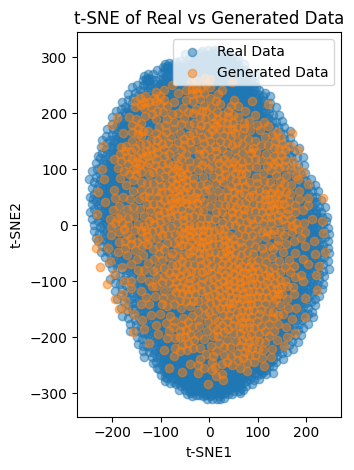

In [41]:
#### Plot t-SNE results for training set vs. generated dataset instance ###

plt.subplot(1, 2, 2)
for dataset, label in zip([tsne_real_data, tsne_generated_data], ['Real Data', 'Generated Data']):
    plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], label=label, alpha=0.5)
plt.title('t-SNE of Real vs Generated Data')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()

plt.tight_layout()
plt.show()

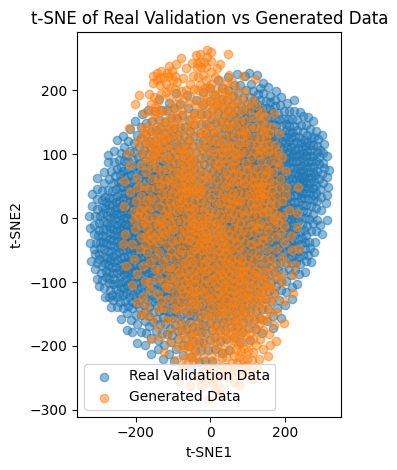

In [42]:
### Plot t-SNE results validation data vs. generated dataset instance ###

plt.subplot(1, 2, 2)
for dataset, label in zip([tsne_real_val_data, tsne_generated_data], ['Real Validation Data', 'Generated Data']):
    plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], label=label, alpha=0.5)
plt.title('t-SNE of Real Validation vs Generated Data')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()

plt.tight_layout()
plt.show()

## Now, use the z_0 vector with 10 sampled vectors from generator network

In [43]:
directory = opt.outf 
filename_template = '/fake_samples_epoch_099_G_z00_m0{0}.csv' # only z0 vector
############################################################## #sampleid+'_G_z00_m0{0}.csv' #'/fake_samples_epoch_099_G_z00_m0{0}.csv'

# List of generated sample files following the full pattern
generated_files = [f'{directory}{filename_template.format(i)}' for i in range(10)]
generated_files

['sim_out_files/fake_samples_epoch_099_G_z00_m00.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m01.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m02.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m03.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m04.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m05.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m06.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m07.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m08.csv',
 'sim_out_files/fake_samples_epoch_099_G_z00_m09.csv']

### PCA

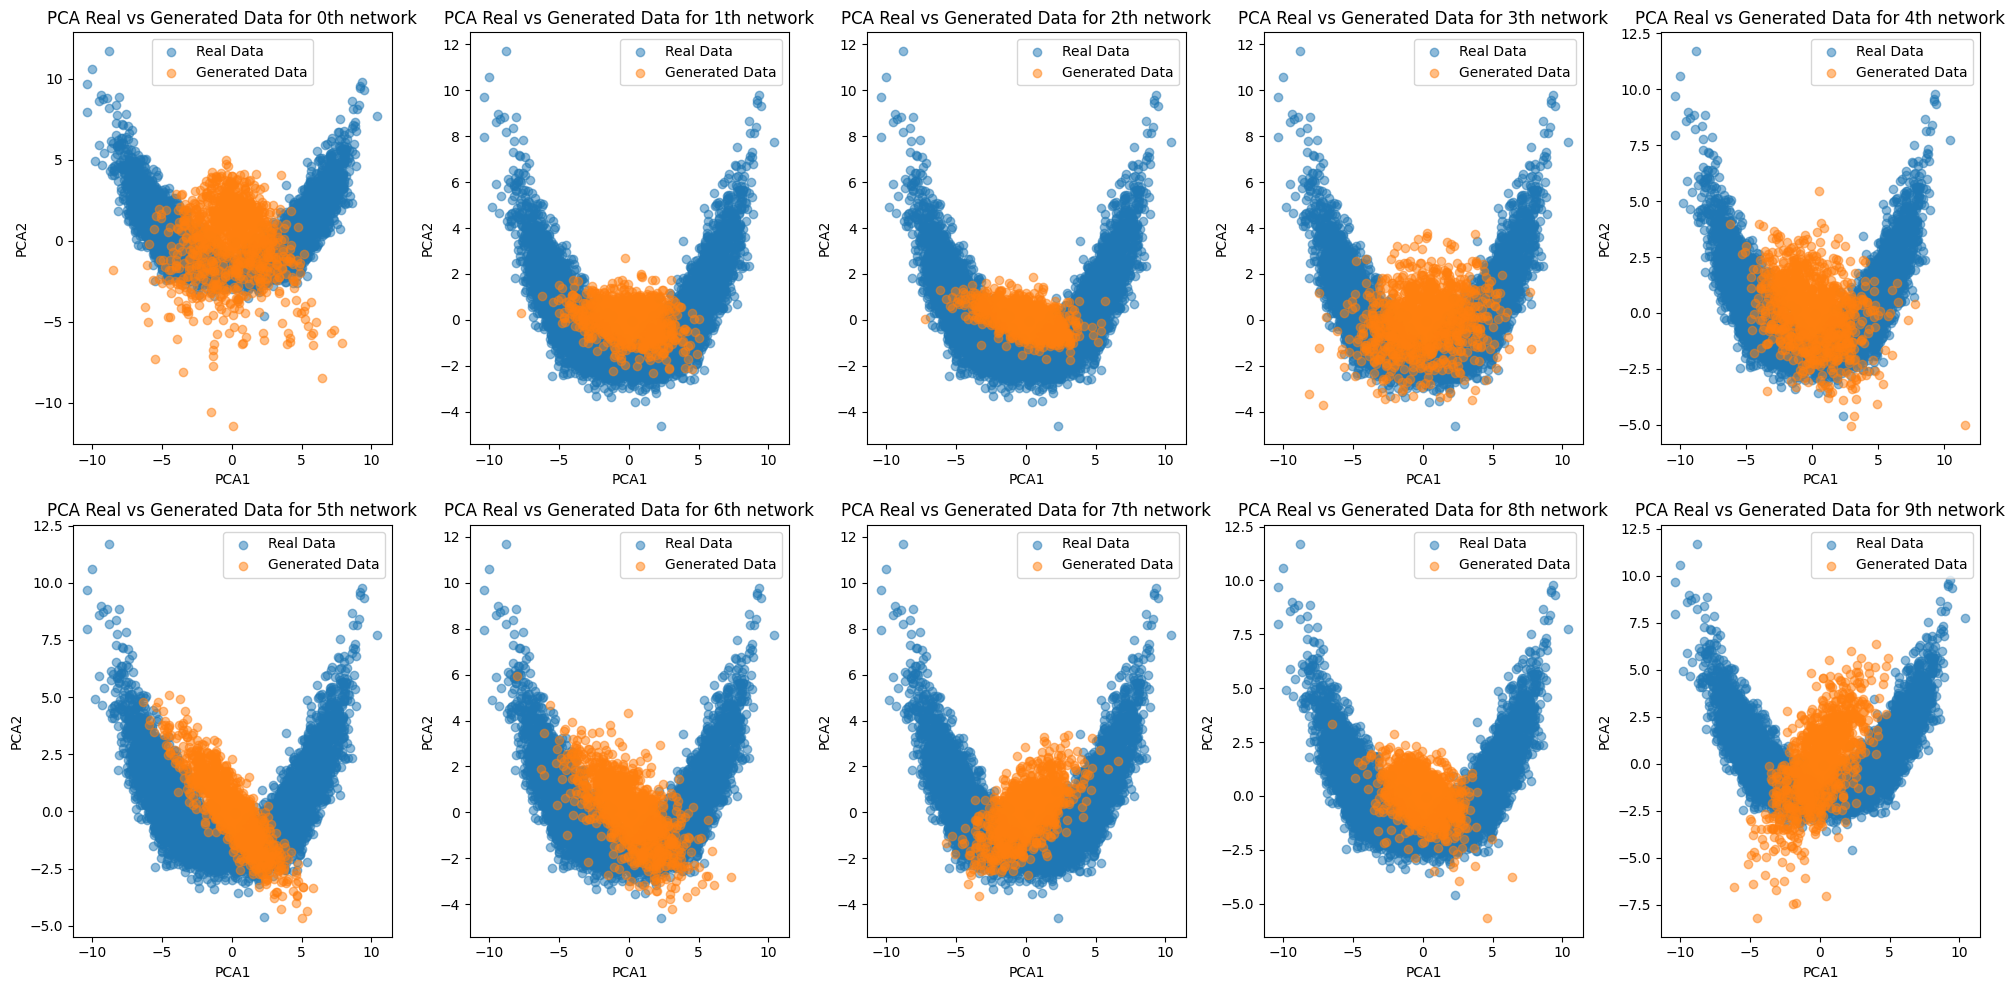

In [44]:
### Plot PCs from samples from the 10 generated network parameters (compared to real training dataset) #####

# pca_real_data from above cell
num_rows = 2  # Adjust based on the number of files and how you want to arrange the grid
num_cols = int(np.ceil(len(generated_files) / num_rows))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterate through generated files and plot PCA results
for i, file in enumerate(generated_files):
    row = i // num_cols
    col = i % num_cols

    # Load generated sample
    generated_data = pd.read_csv(file)


    # Ensure column names and targets are  properly set
    generated_data.columns = real_data.columns #[:-1]

    # Normalize generated data
    exclude_columns = ['y', 'target', 'death', 'response']
    normalize_inplace(generated_data, exclude_columns)

    # Reduce dimensionality with PCA
    num_components = 2
    pca_generated_data = pca.transform(generated_data)

    # Plot PCA results
    axs[row, col].scatter(pca_real_data.iloc[:, 0], pca_real_data.iloc[:, 1], label='Real Data', alpha=0.5)
    axs[row, col].scatter(-pca_generated_data.iloc[:, 0], -pca_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
    axs[row, col].set_title(f'PCA Real vs Generated Data for {i}th network')
    axs[row, col].set_xlabel('PCA1')
    axs[row, col].set_ylabel('PCA2')
    axs[row, col].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [45]:
### Plot PCs from samples from the 10 generated network parameters (compared to real validation dataset) #####

import pandas as pd

scaled_real_data_test = pd.read_csv("test_data.csv") # in case we need to reload the data

# standardize within data set
def normalize_inplace(data, exclude_columns=[]):
    num_cols = len(data.columns)
    for col in data.columns[:num_cols]:
        if col not in exclude_columns:
            data[col] = (data[col] - data[col].mean()) / data[col].std()


num_rows = 2  
num_cols = int(np.ceil(len(generated_files) / num_rows))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterate through generated files and plot PCA results
for i, file in enumerate(generated_files):
    row = i // num_cols
    col = i % num_cols

    # Load generated sample
    generated_data = pd.read_csv(file)

    # Ensure column names and targets are  properly set
    generated_data.columns = scaled_real_data_test.columns #[:-1]

    # Normalize generated data
    exclude_columns = ['y', 'target', 'death', 'response']
    normalize_inplace(generated_data, exclude_columns)

    # PCA
    num_components = 2
    pca_generated_data = pca.transform(generated_data) # two components is default

    # Plot PCA results
    axs[row, col].scatter(pca_real_val_data.iloc[:, 0], pca_real_val_data.iloc[:, 1], label='Real Data', alpha=0.5)
    axs[row, col].scatter(pca_generated_data.iloc[:, 0], pca_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
    axs[row, col].set_title(f'PCA Real vs Generated Data for {i}th network')
    axs[row, col].set_xlabel('PCA1')
    axs[row, col].set_ylabel('PCA2')
    axs[row, col].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### tSNE

In [46]:
# Reduce dimensionality with t-SNE (first, real training set)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cuml.manifold import TSNE #from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
tsne_real_data = tsne.fit_transform(scaled_real_data)

In [47]:
### plot samples from the first 10 generated network parameters (compared to training data) ###

num_rows = 2  
num_cols = int(np.ceil(len(generated_files) / num_rows))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterate through generated files and plot tSNE results
for i, file in enumerate(generated_files):
    row = i // num_cols
    col = i % num_cols

    # Load generated sample
    generated_data = pd.read_csv(file)

    # tSNE of generated
    num_components = 2
    tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
    tsne_generated_data = tsne.fit_transform(generated_data)

    # Plot tSNE results
    axs[row, col].scatter(tsne_real_data.iloc[:, 0], tsne_real_data.iloc[:, 1], label='Real Data', alpha=0.5)
    axs[row, col].scatter(tsne_generated_data.iloc[:, 0], tsne_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
    axs[row, col].set_title(f'tSNE Real vs Generated Data for {i}th network')
    axs[row, col].set_xlabel('tSNE1')
    axs[row, col].set_ylabel('tSNE2')
    axs[row, col].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


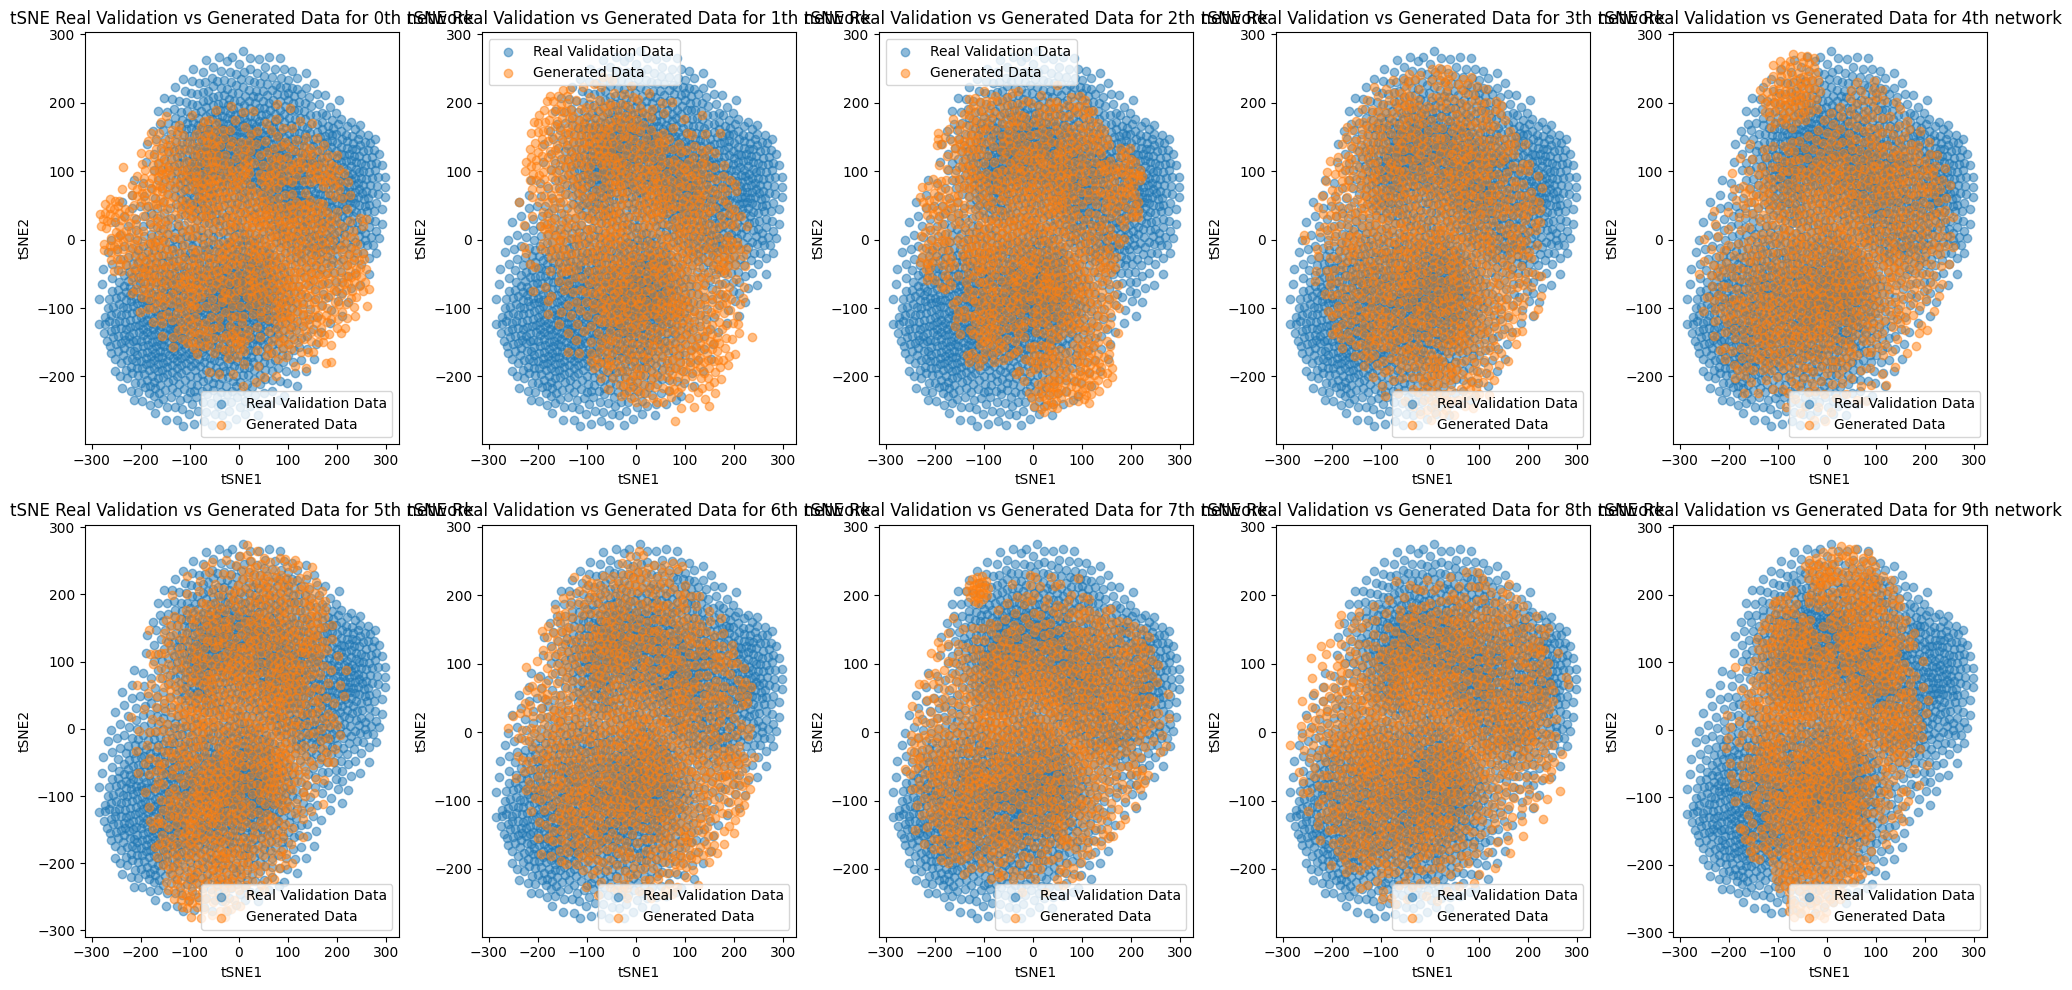

In [48]:
### plot samples from the first 10 generated network parameters (compared to validation data) ###

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
tsne_real_val_data = tsne.fit_transform(scaled_real_data_test)

num_rows = 2  
num_cols = int(np.ceil(len(generated_files) / num_rows))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterate through generated files and plot tSNE results
for i, file in enumerate(generated_files):
    row = i // num_cols
    col = i % num_cols

    # Load generated sample
    generated_data = pd.read_csv(file)

    # tSNE
    num_components = 2
    tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
    tsne_generated_data = tsne.fit_transform(generated_data)

    # Plot tSNE results
    axs[row, col].scatter(tsne_real_val_data.iloc[:, 0], tsne_real_val_data.iloc[:, 1], label='Real Validation Data', alpha=0.5)
    axs[row, col].scatter(tsne_generated_data.iloc[:, 0], tsne_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
    axs[row, col].set_title(f'tSNE Real Validation vs Generated Data for {i}th network')
    axs[row, col].set_xlabel('tSNE1')
    axs[row, col].set_ylabel('tSNE2')
    axs[row, col].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [49]:
## Yet another standardize function

import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_columns(df):
    """Standardizes all columns except the last one in a DataFrame.

    Args:
        df: The DataFrame to standardize.

    Returns:
        The standardized DataFrame.
    """

    # Select all columns except the last one
    columns_to_standardize = df.columns[:-1]

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the data and transform the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    return df

### KS-test (generated compared to training data)

In [50]:
## sample 8000 total samples from 10 generated networks to roughly match training data size (800 samples per generator weight vector)
dfs = [pd.read_csv(file).sample(n=800, random_state=1) for file in generated_files]

# to use the flat_gnerated files above
#dfs = [pd.read_csv(file).sample(n=1000, random_state=1) for file in flat_generated_files]

# Apply the function to each DataFrame in the list
dfs = [standardize_columns(df) for df in dfs]

combined_generated_data = pd.concat(dfs, ignore_index=True)

combined_generated_data.columns = scaled_real_data.columns
combined_generated_data

0         1         2         3         4         5         6  \
0     0.926542 -0.322486 -0.061430  0.720614 -0.434657 -0.762397  0.116864   
1     0.252104  0.285556  0.226811  1.457520  0.558333  0.999659  0.188791   
2     0.367188  0.101926 -0.408411  0.549910  0.309384 -0.048871  0.559269   
3     0.428586 -0.194953 -0.305590 -0.927470  0.597117  0.267232  0.411090   
4     1.351873 -0.112193 -0.248367 -0.427331 -0.644479  1.142802  0.653169   
...        ...       ...       ...       ...       ...       ...       ...   
7995  0.459576 -1.067932  0.463272 -0.250544 -2.306523 -0.205586 -1.232507   
7996 -1.569807 -0.932214  1.518330  1.050004  0.260522 -0.852977 -2.576353   
7997 -0.565667 -0.875184  0.023767  0.214925 -0.466993 -0.316190 -0.155576   
7998 -0.734148  0.884904  0.101084  0.385487  0.287098 -0.866020 -0.528207   
7999  0.890772  1.397104  0.650676 -0.207447  1.012522  0.478028 -0.731129   

             7         8         9  ...        29        30        31  \
0    -0.719403 -1.129068  0.137738  ... -1.220001 -1.026379 -0.644306   
1     0.902325  0.163459 -1.028743  ... -0.850669  0.000032 -0.610752   
2    -0.681831 -1.518385  0.323099  ... -0.100670  0.082108 -0.675449   
3    -1.032868 -0.939454  1.070487  ...  0.024103 -0.720386 -0.244526   
4     0.682710  0.443408 -1.041863  ... -0.150442  0.195300 -0.097402   
...        ...       ...       ...  ...       ...       ...       ...   
7995 -1.764754 -1.962931 -0.690397  ... -1.915774  1.148468  1.107783   
7996  1.273789 -1.330060  0.061963  ... -2.007003  1.383272  2.548202   
7997  0.506536 -0.692314 -0.689192  ... -0.685288  0.689679  0.803406   
7998  0.500973  0.488671  0.081853  ... -0.120255 -0.258463  0.459737   
7999 -0.540252  1.682986  1.808769  ...  1.291449 -1.168290 -1.291990   

            32        33        34        35        36        37  response  
0    -1.153839 -0.705292 -1.006461 -0.813843 -0.923698 -1.012090       0.0  
1    -0.653145 -0.451482 -0.073386 -0.148162 -0.688991 -0.747033       0.0  
2    -0.281141 -0.533018 -0.768528 -0.686002 -0.194108 -0.710940       0.0  
3    -0.263210 -0.141128 -1.142523 -1.031716  0.023115 -0.679360       0.0  
4    -1.746538 -0.461801 -0.450419  0.581878 -0.525353 -1.233208       0.0  
...        ...       ...       ...       ...       ...       ...       ...  
7995 -0.270852 -0.749620  0.671191  1.201077  0.381152  0.554785       1.0  
7996 -0.913724  1.217971 -0.422229  2.075135  1.854957  2.145134       1.0  
7997 -0.160176  0.618066  0.634656  0.503908  0.881841  0.564712       1.0  
7998 -1.993276  1.506961 -0.569156  0.178988  0.737678 -0.169916       1.0  
7999  1.353249 -1.126574 -0.501372 -1.564492 -1.725751 -1.254421       1.0  

[8000 rows x 39 columns]

In [51]:
### KS-test to compare datasets
from scipy.stats import ks_2samp

# Perform KS test for each corresponding column
ks_results = {}
for column in combined_generated_data.columns:
    stat, p_value = ks_2samp(combined_generated_data[column], scaled_real_data[column])
    ks_results[column] = {'Statistic': stat, 'P-Value': p_value}

# Convert results to DataFrame for better visualization
ks_results_df = pd.DataFrame.from_dict(ks_results, orient='index')
print(ks_results_df)

          Statistic       P-Value
0          0.033750  2.203014e-04
1          0.031875  5.897295e-04
2          0.033875  2.058917e-04
3          0.031000  9.158995e-04
4          0.034875  1.187675e-04
5          0.027750  4.220682e-03
6          0.030750  1.036327e-03
7          0.035750  7.242982e-05
8          0.033375  2.694640e-04
9          0.041500  2.070028e-06
10         0.038375  1.526216e-05
11         0.031125  8.607168e-04
12         0.030125  1.405134e-03
13         0.028250  3.373505e-03
14         0.028500  3.011471e-03
15         0.034750  1.273344e-04
16         0.032875  3.512560e-04
17         0.035875  6.742170e-05
18         0.031625  6.696122e-04
19         0.029250  2.129429e-03
20         0.030500  1.171416e-03
21         0.033500  2.520277e-04
22         0.033625  2.356607e-04
23         0.035875  6.742170e-05
24         0.037375  2.798387e-05
25         0.029375  2.008154e-03
26         0.026750  6.527849e-03
27         0.038000  1.919401e-05
28         0.0

### Compare histograms (generated vs. training set)

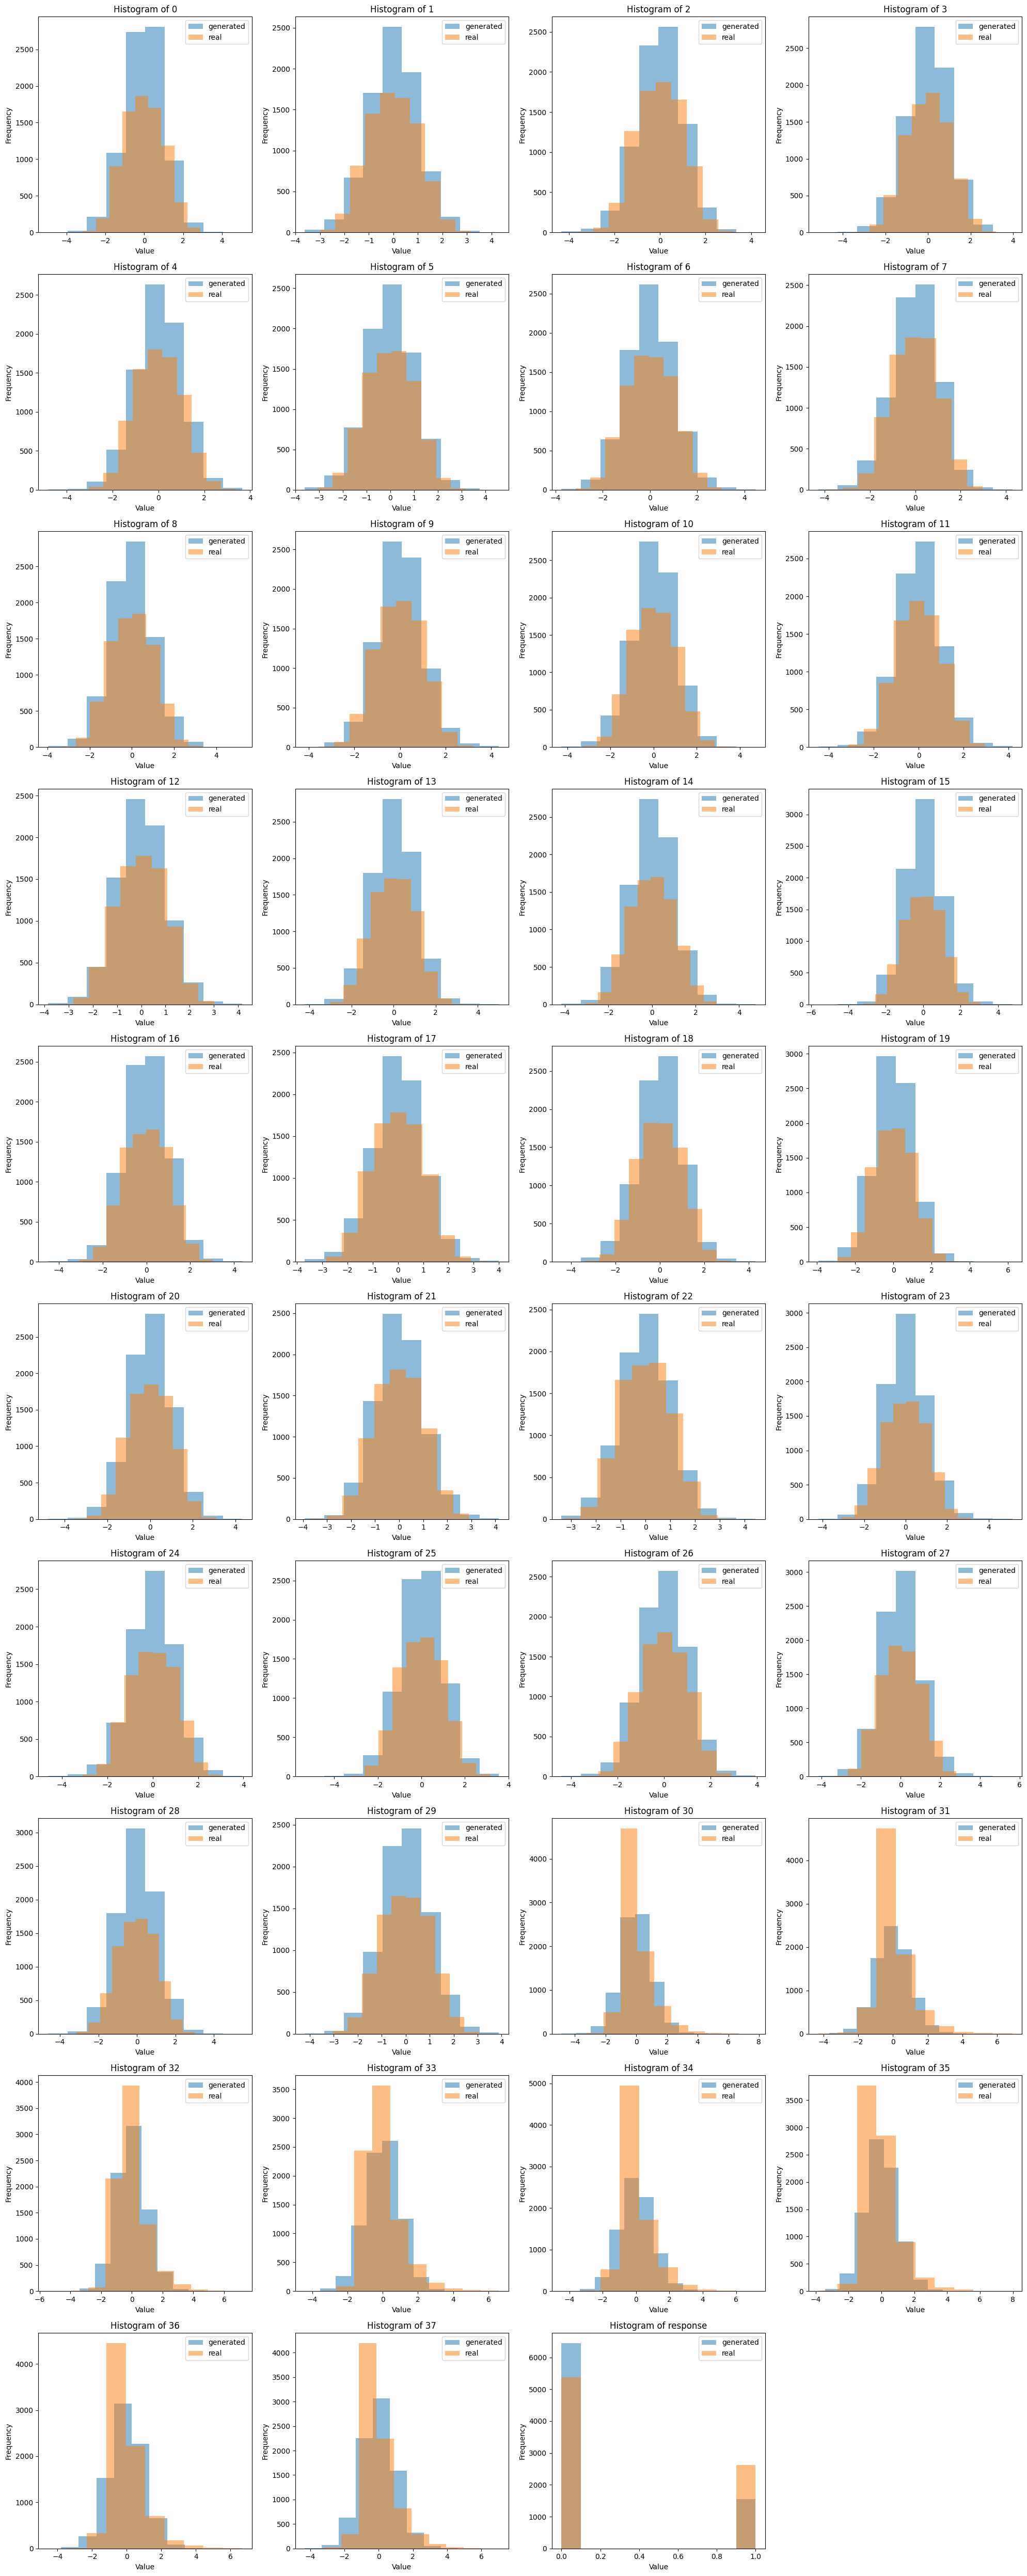

In [52]:
# Calculate number of rows and columns for the subplot grid
n_cols = len(combined_generated_data.columns)
n_rows = (n_cols + 3) // 4  # Assuming 4 columns in the grid

# Create a figure and axis object
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))
axes = axes.flatten()  # Flatten for easier iteration

for i, col in enumerate(combined_generated_data.columns):
    ax = axes[i]
    combined_generated_data[col].hist(ax=ax, alpha=0.5, label='generated', density=False)
    scaled_real_data[col].hist(ax=ax, alpha=0.5, label='real', density=False)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {col}')
    ax.legend()
    ax.grid(False)

# Hide any unused subplots
for ax in axes[i+1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## MDS: $m=10$ weight vectors for each $\mathbf{z}_i$ (opt.numz of them)

In [53]:
import numpy as np

# Define the directory and filename template
results_dir = "sim_out_files"  # accidentally used the incorrect directory. But the MDS plot is similar
filename_template = "generator_wts_epoch_099_G_z%02d_m%02d.csv"

# Load the weights for each combination of z and m
all_weights = []
all_wgt_files = []
for z in range(25):  # opt.numz here
    for m in range(10):
        filename = f"{results_dir}/{filename_template % (z, m)}"
        weights = np.loadtxt(filename, delimiter=',')
        all_weights.append(weights)
        all_wgt_files.append(filename)

# Now we have a list of NumPy arrays containing the weights for each combination of z and m
print(all_wgt_files)



['sim_out_files/generator_wts_epoch_099_G_z00_m00.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m01.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m02.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m03.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m04.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m05.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m06.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m07.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m08.csv', 'sim_out_files/generator_wts_epoch_099_G_z00_m09.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m00.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m01.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m02.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m03.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m04.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m05.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m06.csv', 'sim_out_files/generator_wts_epoch_099_G_z01_m07.csv', 'sim_out_

In [54]:
## change to np array
all_weights = np.array(all_weights)
all_weights.shape

(250, 71695)

In [55]:
from sklearn.manifold import MDS
seed = np.random.RandomState(seed=3)

mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
          dissimilarity="euclidean", metric=True)
pos = mds.fit(all_weights).embedding_

/home/lxt/bGAN_pytorch_clone/bGAN_pytorch/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5236/532637685.py:5: SyntaxWarning: invalid escape sequence '\m'


(np.float64(-51.60620787702056),
 np.float64(51.63244951461168),
 np.float64(-50.632153378825244),
 np.float64(51.48835718730666))

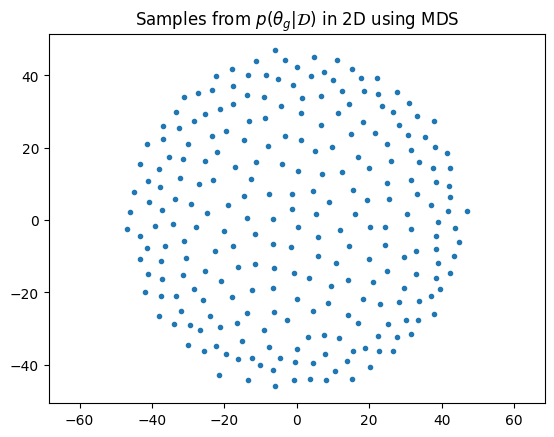

In [56]:
import matplotlib.pyplot as plt 

plt.figure() # Call the figure function from the plt module
plt.plot(pos[:, 0], pos[:, 1], '.')
plt.title("Samples from $p(\\theta_{g} | \mathcal{D})$ in 2D using MDS")
plt.axis("equal")

## Now, use all 10 weight samples combined using the $\mathbf{z}_0$ noise vector (may need more $\mathbf{z}_i$'s because this is biased from the one $\mathbf{z}_0$ vector)

Here we combine all the generator samples from the 10 weight vectors into one sample to compare to training data. However, we still use only the first noise vector.

### PCA (training set compared to generated dataset instance)

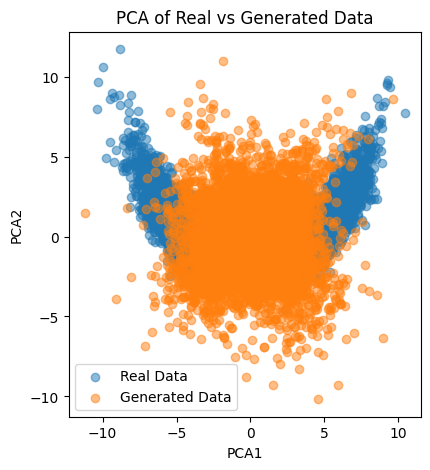

In [57]:
# Reduce dimensionality with PCA
from cuml.decomposition import PCA
pca = PCA(n_components=2)

pca_real_data=pca.fit_transform(scaled_real_data) 
pca_generated_data = pca.fit_transform(combined_generated_data) 

import matplotlib.pyplot as plt
%matplotlib inline
# Plot PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_real_data.iloc[:, 0], pca_real_data.iloc[:, 1], label='Real Data', alpha=0.5)
plt.scatter(pca_generated_data.iloc[:, 0], pca_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA of Real vs Generated Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

### tSNE (generated compared to training data)

In [58]:
# Reduce dimensionality with t-SNE
from cuml.manifold import TSNE #from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
#tsne_real_data = tsne.fit_transform(scaled_real_data)
tsne_generated_data = tsne.fit_transform(combined_generated_data)

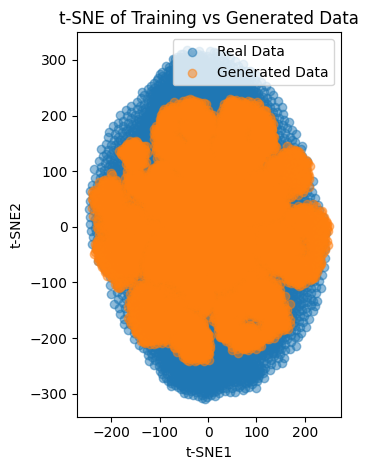

In [59]:
# Plot t-SNE results
plt.subplot(1, 2, 2)
for dataset, label in zip([tsne_real_data, tsne_generated_data], ['Real Data', 'Generated Data']):
    plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], label=label, alpha=0.5)
plt.title('t-SNE of Training vs Generated Data')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()

plt.tight_layout()
plt.show()

### Use PCA and tSNE to compare combined generated data to validation data too (too overwhelming; validation data only had 2000 rows)
### Later, we obtain only 2000 generated samples to have a better comparison

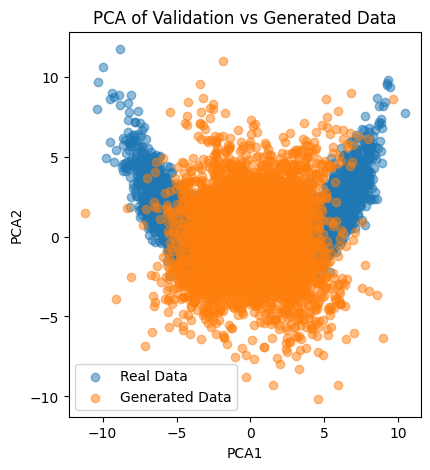

In [60]:
# Reduce dimensionality with PCA
from cuml.decomposition import PCA
num_components = 2
pca_real_val_data = pca.fit_transform(scaled_real_data_test)
pca_generated_data = pca.fit_transform(combined_generated_data)

import matplotlib.pyplot as plt
%matplotlib inline
# Plot PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_real_data.iloc[:, 0], pca_real_data.iloc[:, 1], label='Real Data', alpha=0.5)
plt.scatter(pca_generated_data.iloc[:, 0], pca_generated_data.iloc[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA of Validation vs Generated Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

In [61]:
# Not sure we use this csv file at all. Might be left over from old stuff
save_fake_data(scaled_real_data, 'real_data.csv' ) # scaled_real_data.to_csv('real_data.csv', index=False)

# Now, use the first 10 $\mathbf{z}_i$'s (out of a total of opt.numz) and use all $\mathbf{m}_j$'s (weights) in each $\mathbf{z}_i$

In [62]:
## Each weight vector is a different "study" for the hierarchical model later

# Create an empty dictionary to store the lists
allzallm_generated_files = {}

directory = 'sim_out_files/'
filename_template ='fake_samples_epoch_099_G_z0{1}_m0{0}.csv'

# Iterate over both placeholders and populate the dictionary
for i in range(10):
    for j in range(10):
        filename = f'{directory}{filename_template.format(i, j)}'
        if i not in allzallm_generated_files:
            allzallm_generated_files[i] = []
        allzallm_generated_files[i].append(filename)

# Access the lists
print(allzallm_generated_files[0])  # Files with m0
print(allzallm_generated_files[1])  # Files with m1
### etc

['sim_out_files/fake_samples_epoch_099_G_z00_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z01_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z02_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z03_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z04_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z05_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z06_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z07_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z08_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z09_m00.csv']
['sim_out_files/fake_samples_epoch_099_G_z00_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z01_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z02_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z03_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z04_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z05_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z06_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z07_m01.csv', 'sim_out_files/fake_sample

In [63]:
# Flatten the list using itertools.chain
 
import itertools

flat_generated_files = list(itertools.chain.from_iterable(allzallm_generated_files.values()))

# Print the flattened list
print(flat_generated_files)

['sim_out_files/fake_samples_epoch_099_G_z00_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z01_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z02_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z03_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z04_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z05_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z06_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z07_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z08_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z09_m00.csv', 'sim_out_files/fake_samples_epoch_099_G_z00_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z01_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z02_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z03_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z04_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z05_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z06_m01.csv', 'sim_out_files/fake_samples_epoch_099_G_z07_m01.csv', 'sim_out_files/fake_samples

In [64]:
## sample 8000 total from 10 generated networks and 10 z's to roughly match real training data size (800 per generator weight vector)

import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_columns(df):

    # Select all columns except the last one
    columns_to_standardize = df.columns[:-1]

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the data and transform the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    return df

dfs = [pd.read_csv(file).sample(n=80, random_state=1) for file in flat_generated_files] # to use the flat_gnerated files above

# Apply the function to each DataFrame in the list
dfs = [standardize_columns(df) for df in dfs]

combined_generated_data_allzm = pd.concat(dfs, ignore_index=True)

combined_generated_data_allzm.columns = scaled_real_data.columns
combined_generated_data_allzm

0         1         2         3         4         5         6  \
0     0.814136 -0.343559 -0.162120  0.673677 -0.481127 -0.609903  0.105627   
1     0.146722  0.309922  0.161289  1.309496  0.622900  0.954952  0.174772   
2     0.260607  0.112569 -0.551436  0.526391  0.346114  0.023769  0.530917   
3     0.321365 -0.206496 -0.436069 -0.748325  0.666022  0.304495  0.388471   
4     1.235037 -0.117551 -0.371865 -0.316794 -0.714411  1.082075  0.621185   
...        ...       ...       ...       ...       ...       ...       ...   
7995 -2.252013 -1.304203 -1.823597  0.103589  0.293850 -0.172029 -1.476675   
7996 -0.397098  1.252389 -1.323139 -0.848328  1.270462 -0.944757  0.076418   
7997 -0.222057 -0.201700 -0.381964 -0.628776  1.038882  0.692993  0.037198   
7998  0.499426  0.719566  0.048671 -0.859959  0.769709 -0.171158  0.686196   
7999 -0.887956  0.554132 -1.187824 -0.032541  0.534573 -0.354388 -0.657157   

             7         8         9  ...        29        30        31  \
0    -0.573248 -0.984582  0.070714  ... -1.214189 -0.921817 -0.573343   
1     0.925559  0.293209 -0.947590  ... -0.862498  0.094472 -0.539976   
2    -0.538523 -1.369461  0.232529  ... -0.148321  0.175739 -0.604312   
3    -0.862953 -0.797130  0.884978  ... -0.029508 -0.618842 -0.175796   
4     0.722589  0.569966 -0.959044  ... -0.195716  0.287815 -0.029494   
...        ...       ...       ...  ...       ...       ...       ...   
7995 -0.493422  0.429192 -2.338922  ... -2.063310  0.649831  1.486733   
7996 -0.467707 -0.409179  0.352485  ... -2.444360 -1.010798 -1.282928   
7997 -1.466107  0.101594  0.170430  ...  0.121464 -0.309199 -0.182635   
7998  0.310926  0.306290  1.043628  ... -1.325705 -0.648228 -0.893994   
7999  0.637297 -0.953155 -0.511181  ... -2.652528 -0.509823 -0.169318   

            32        33        34        35        36        37  response  
0    -1.045862 -0.621801 -0.888075 -0.757317 -0.900272 -0.912269       0.0  
1    -0.593542 -0.359031 -0.008401 -0.116823 -0.659668 -0.666764       0.0  
2    -0.257479 -0.443446 -0.663759 -0.634312 -0.152349 -0.633333       0.0  
3    -0.241281 -0.037720 -1.016350 -0.966946  0.070331 -0.604083       0.0  
4    -1.581296 -0.369715 -0.363857  0.585595 -0.491918 -1.117076       0.0  
...        ...       ...       ...       ...       ...       ...       ...  
7995 -0.124858  0.443163  0.010644  1.103900 -0.879423 -1.673950       0.0  
7996  0.372199  0.498481 -0.945613  0.980000 -0.161970 -0.878160       0.0  
7997  0.501820  0.235533 -0.374620  1.332695  0.265893  0.261475       0.0  
7998  0.375172 -0.329299 -0.488264  0.191813  0.382012  0.034510       0.0  
7999 -0.543540  0.020043  0.075278  0.564394  0.162356  0.855596       0.0  

[8000 rows x 39 columns]

## Compare to training data

In [65]:
## If we dont have scaled training data from above, run this ##
import pandas as pd
scaled_real_data = pd.read_csv("training_data.csv")

### Histograms comparing generated to training data

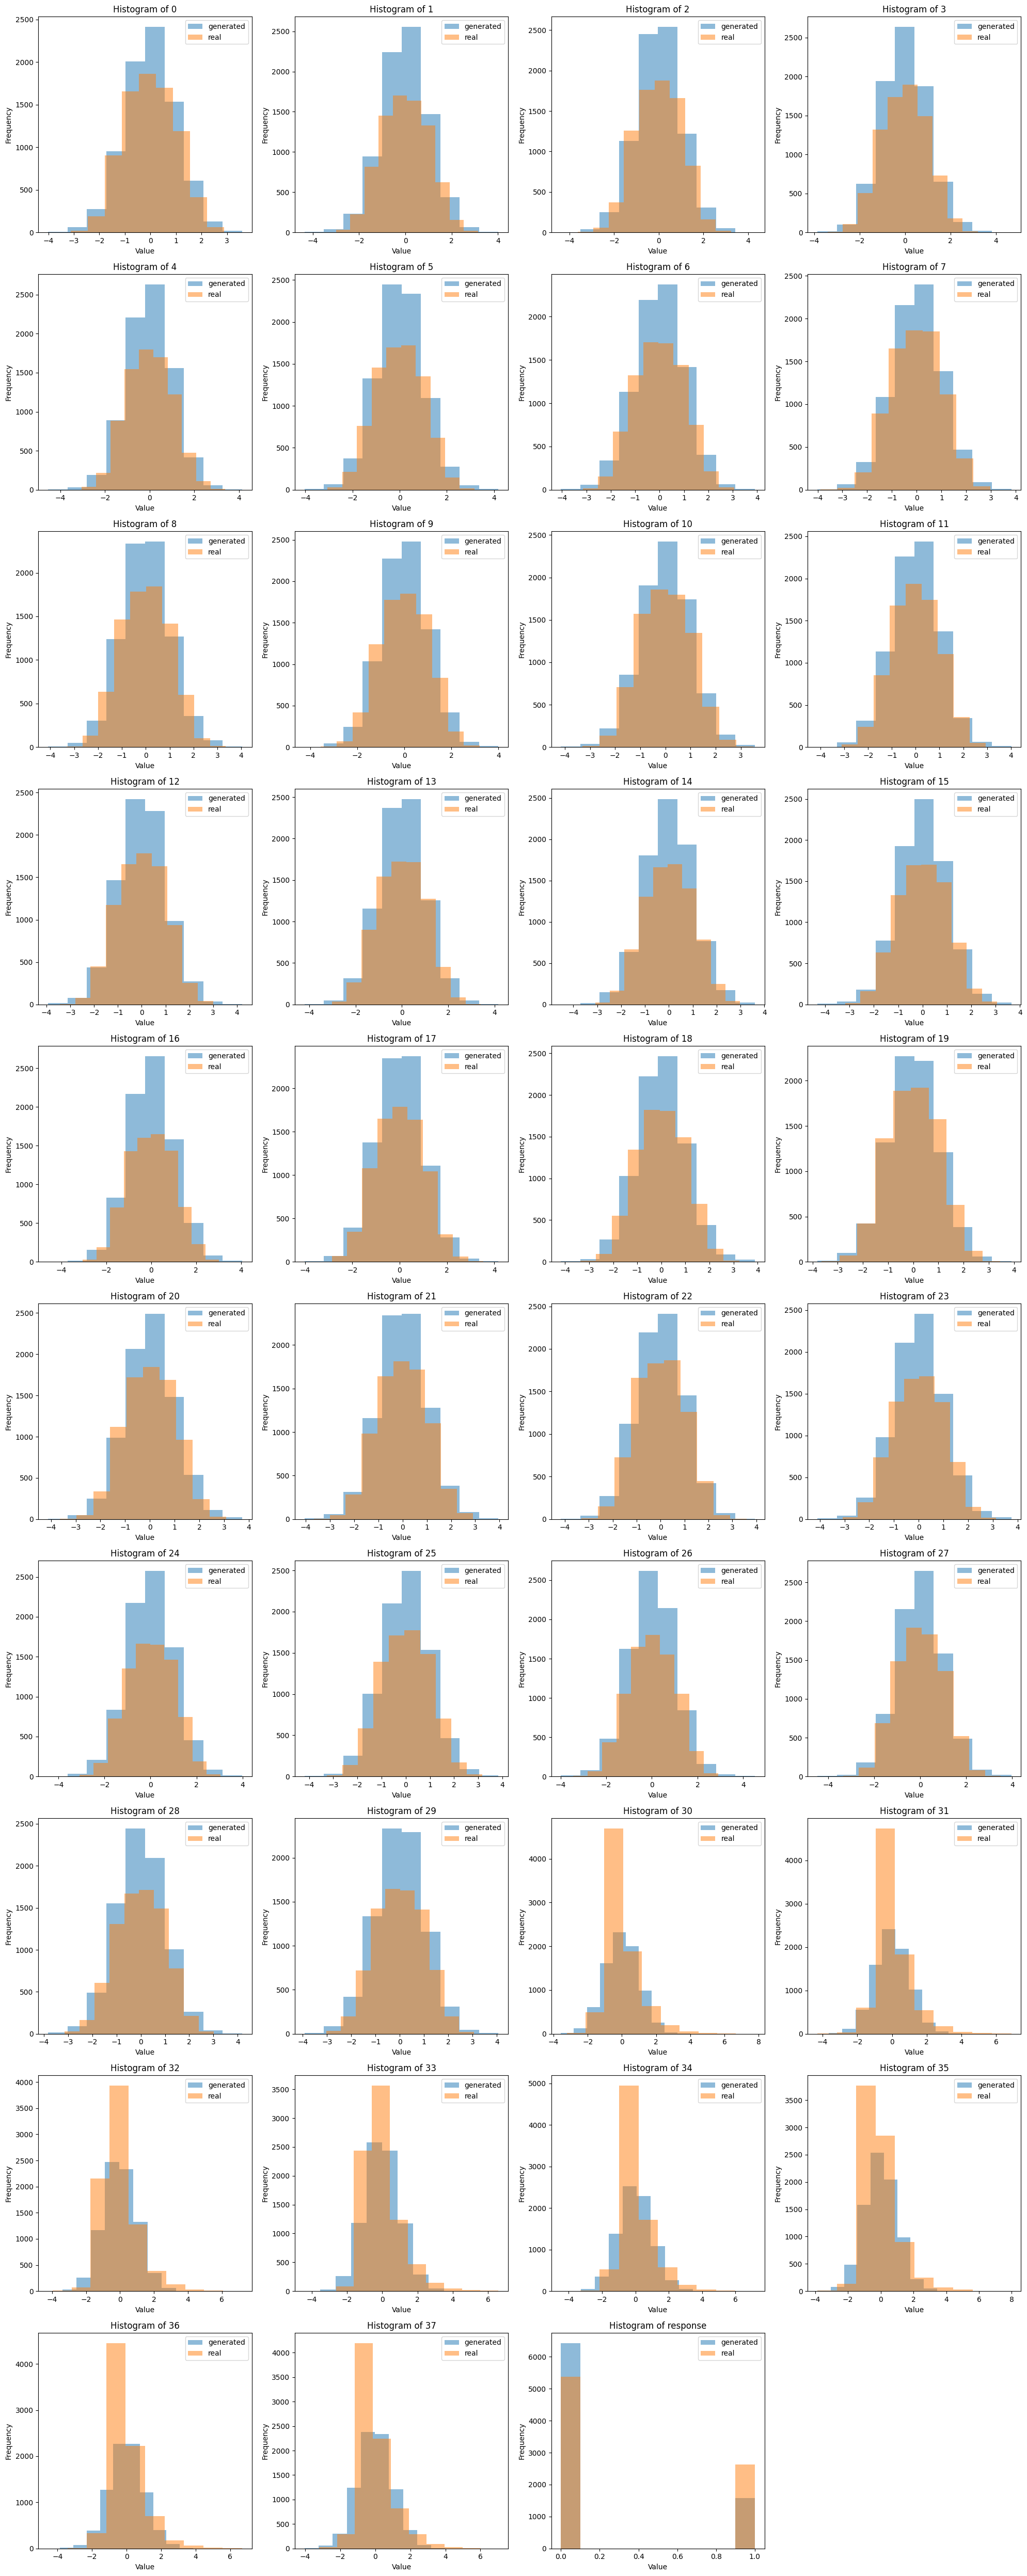

In [66]:
import matplotlib.pyplot as plt

# Calculate number of rows and columns for the subplot grid
n_cols = len(combined_generated_data_allzm.columns)
n_rows = (n_cols + 3) // 4  # Assuming 4 columns in the grid

# Create a figure and axis object
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))
axes = axes.flatten()  # Flatten for easier iteration

for i, col in enumerate(combined_generated_data_allzm.columns):
    ax = axes[i]
    combined_generated_data_allzm[col].hist(ax=ax, alpha=0.5, label='generated', density=False)
    scaled_real_data[col].hist(ax=ax, alpha=0.5, label='real', density=False)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {col}')
    ax.legend()
    ax.grid(False)

# Hide any unused subplots
for ax in axes[i+1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


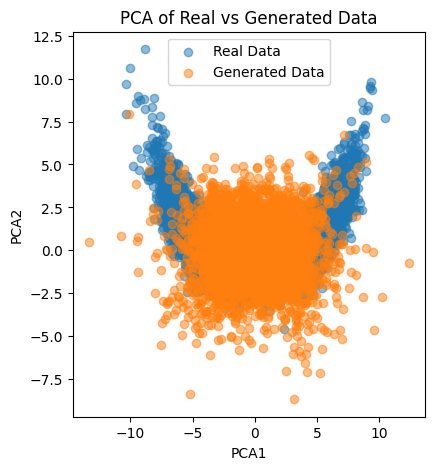

In [67]:
# Reduce dimensionality with PCA 
pca = PCA(n_components=2) # can use cuml or sklearn
pca_real_data = pca.fit_transform(scaled_real_data)
pca_real_val_data = pca.fit_transform(scaled_real_data_test)

pca_generated_data_allzm = pca.transform(combined_generated_data_allzm)

import matplotlib.pyplot as plt
%matplotlib inline

# Plot PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_real_data.iloc[:, 0], pca_real_data.iloc[:, 1], label='Real Data', alpha=0.5)
plt.scatter(-pca_generated_data_allzm.iloc[:, 0], -pca_generated_data_allzm.iloc[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA of Real vs Generated Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

In [68]:
scaled_real_data = pd.read_csv("real_data.csv")

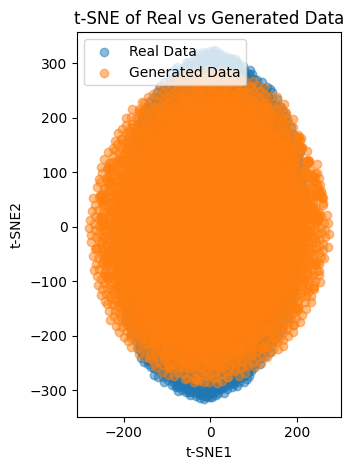

In [69]:
# Reduce dimensionality with t-SNE (can use cuml or sklearn; here, cuml)
tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
tsne_real_data = tsne.fit_transform(scaled_real_data)
tsne_generated_data_all = tsne.fit_transform(combined_generated_data_allzm)

# Plot t-SNE results
plt.subplot(1, 2, 2)
for dataset, label in zip([tsne_real_data, tsne_generated_data_all], ['Real Data', 'Generated Data']):
    plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], label=label, alpha=0.5)
plt.title('t-SNE of Real vs Generated Data')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()

plt.tight_layout()
plt.show()

## Compare to validation data

In [70]:
## If we dont have scaled (validation) test data from above, run this ##
import pandas as pd
scaled_real_val_data = pd.read_csv("test_data.csv")

In [71]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_columns(df):

    # Select all columns except the last one
    columns_to_standardize = df.columns[:-1]

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the data and transform the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    return df


# to use the flat_gnerated files above (need to run cells before this)

## sample 20 to compare with validation set of size 2000
dfs = [pd.read_csv(file).sample(n=20, random_state=1) for file in flat_generated_files]

# Apply the function to each DataFrame in the list
dfs = [standardize_columns(df) for df in dfs]

combined_generated_data_allzm_20 = pd.concat(dfs, ignore_index=True)

combined_generated_data_allzm_20.columns = scaled_real_val_data.columns
combined_generated_data_allzm_20

0         1         2         3         4         5         6  \
0     0.709825 -0.425386 -0.070053  0.611890 -0.533736 -1.137044 -0.070364   
1     0.098603  0.319172  0.283605  1.279362  0.531403  0.975064  0.016424   
2     0.202900  0.094313 -0.495784  0.457271  0.264366 -0.281768  0.463445   
3     0.258543 -0.269220 -0.369626 -0.880905  0.573006  0.097132  0.284652   
4     1.095290 -0.167879 -0.299417 -0.427891 -0.758802  1.146644  0.576746   
...        ...       ...       ...       ...       ...       ...       ...   
1995  1.871149 -2.470363  0.177018 -2.228816 -2.485297 -1.170583  1.581979   
1996 -0.428605 -0.477798 -0.741522  0.759880 -0.255759  0.242104 -0.360008   
1997 -1.047104  0.933925 -0.592586  0.134752  0.680336 -0.435398 -0.815330   
1998 -1.407103  0.756590 -1.560284  1.131089  0.639346 -0.458257 -1.877592   
1999 -0.210097  1.844448 -1.691723  1.640645 -0.914855 -2.008620 -1.823725   

             7         8         9  ...        29        30        31  \
0    -0.700206 -0.817285  0.153801  ... -0.971516 -0.828291 -0.413104   
1     1.254374  0.356301 -0.779930  ... -0.647828  0.128187 -0.384839   
2    -0.654922 -1.170776  0.302176  ...  0.009483  0.204671 -0.439338   
3    -1.078008 -0.645120  0.900437  ...  0.118835 -0.543147 -0.076343   
4     0.989683  0.610488 -0.790432  ... -0.034139  0.310151  0.047590   
...        ...       ...       ...  ...       ...       ...       ...   
1995 -1.801485  0.476648  0.713726  ...  1.993066 -0.990327 -0.897007   
1996 -0.127728  0.707480 -1.272507  ... -0.531985  1.226856  0.695486   
1997 -0.871950 -1.357441  0.479951  ... -0.126756  0.783086 -0.422800   
1998  0.020804 -0.670908 -0.338539  ... -1.423444  0.589088  0.103291   
1999  1.156511 -2.795565  2.295548  ... -1.567850  1.362297 -2.153446   

            32        33        34        35        36        37  response  
0    -0.848375 -0.498365 -0.793488 -0.680316 -0.991975 -0.811720       0.0  
1    -0.420381 -0.254966  0.040455 -0.083604 -0.740090 -0.573375       0.0  
2    -0.102391 -0.333157 -0.580834 -0.565719 -0.208984 -0.540919       0.0  
3    -0.087064  0.042657 -0.915094 -0.875615  0.024137 -0.512522       0.0  
4    -1.355015 -0.264862 -0.296522  0.570798 -0.564474 -1.010554       0.0  
...        ...       ...       ...       ...       ...       ...       ...  
1995  1.289993 -0.565015 -2.361519 -1.909823  1.051033 -0.057385       0.0  
1996 -0.795472  0.388008  0.822558  0.428812 -0.847756 -1.486936       0.0  
1997 -0.249449  0.126342  0.338411  0.445771 -0.274083  0.141276       0.0  
1998 -1.309964 -1.437854  1.523772  0.999347 -1.615561 -1.238659       0.0  
1999 -3.047251 -2.547919  1.035732  0.834993 -1.853344  0.175764       0.0  

[2000 rows x 39 columns]

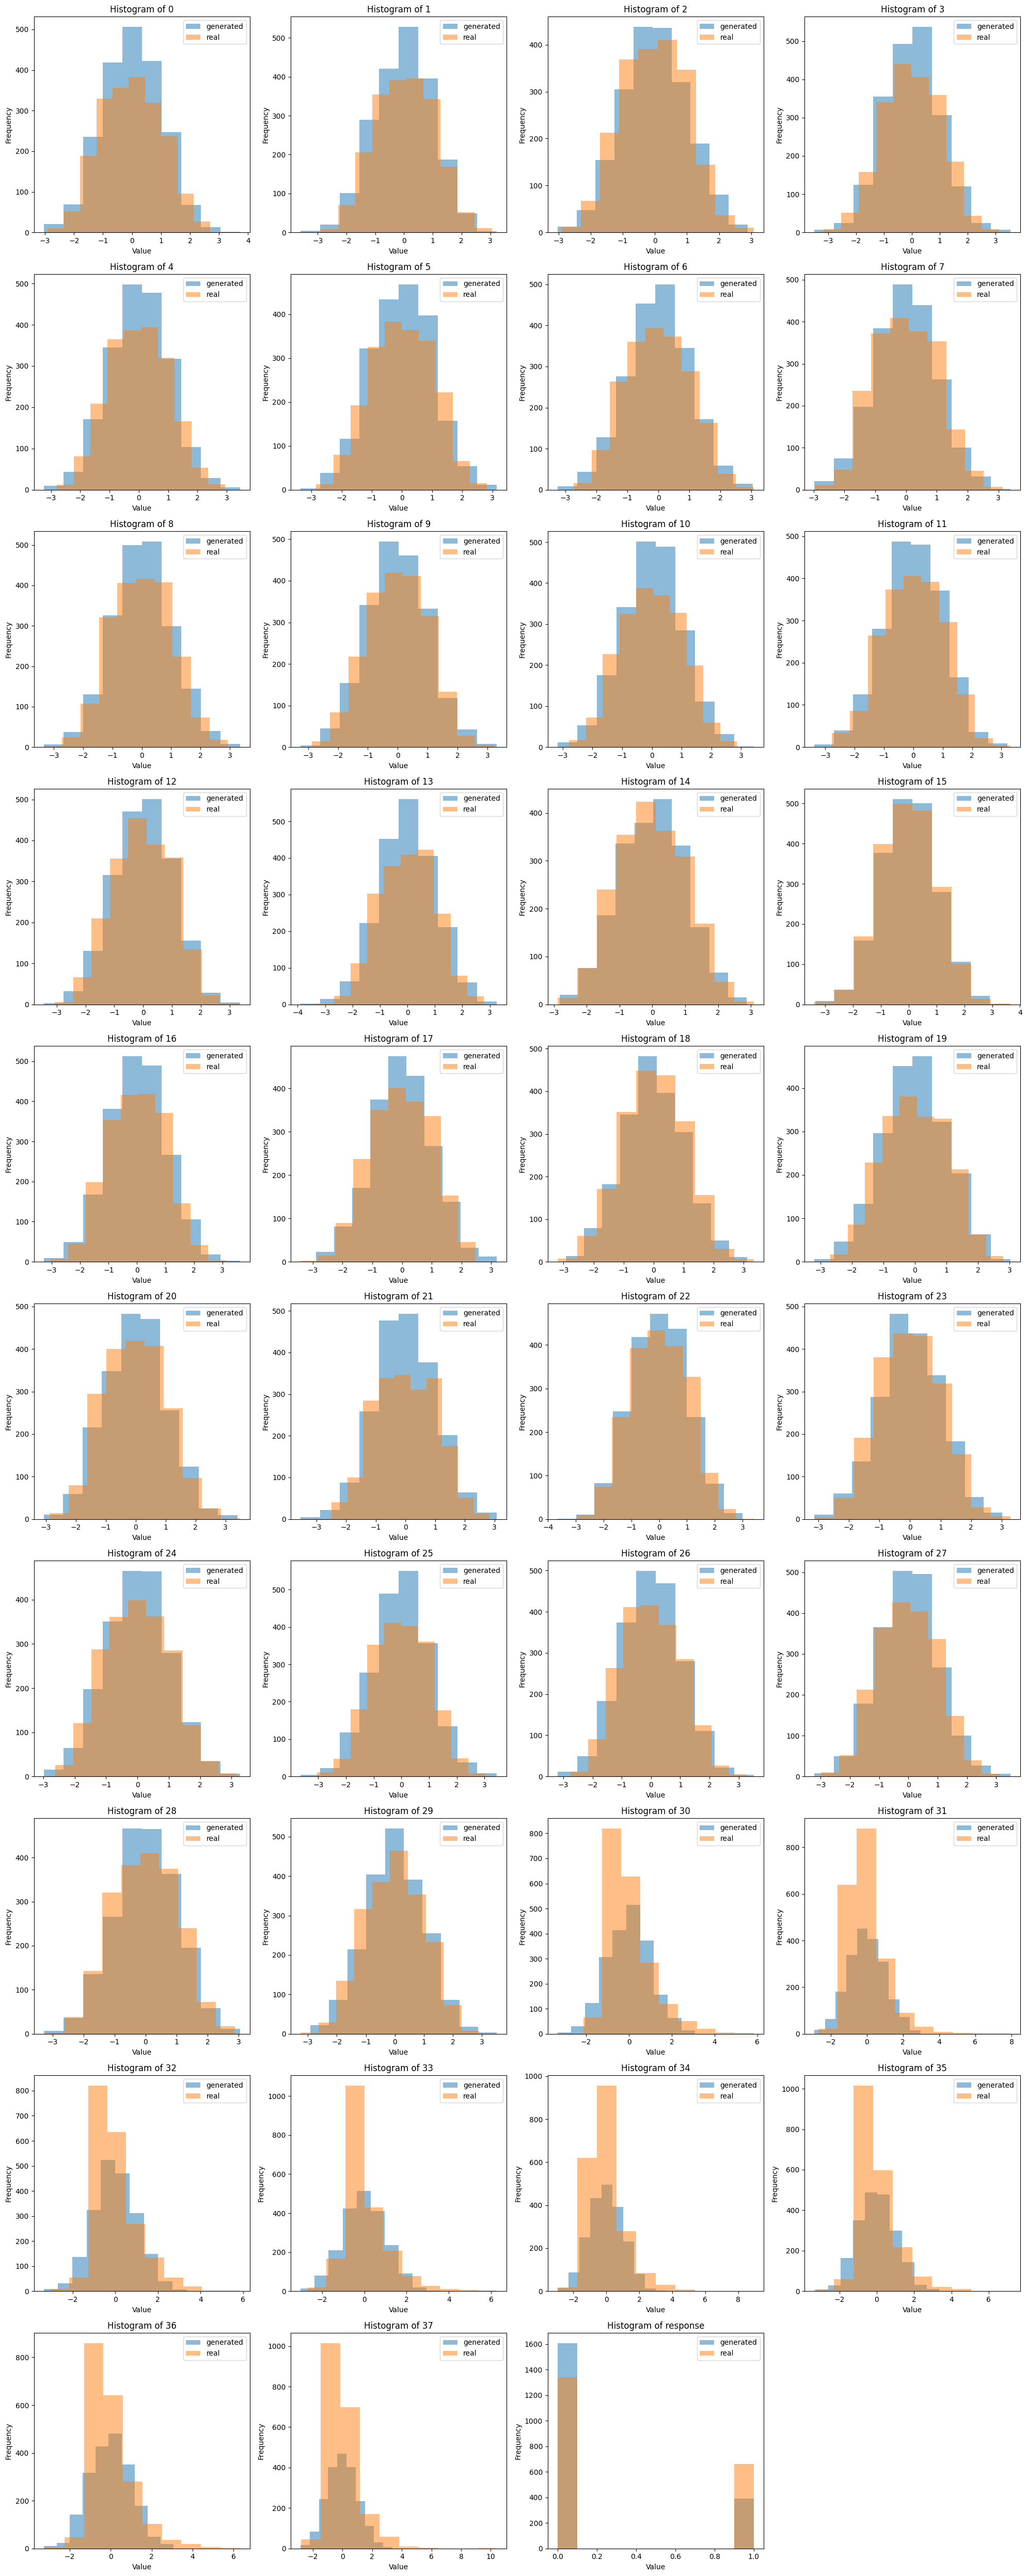

In [72]:
# Plotting

# Calculate number of rows and columns for the subplot grid
n_cols = len(combined_generated_data_allzm_20.columns)
n_rows = (n_cols + 3) // 4  # Assuming 4 columns in the grid

# Create a figure and axis object
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))
axes = axes.flatten()  # Flatten for easier iteration

for i, col in enumerate(combined_generated_data_allzm_20.columns):
    ax = axes[i]
    combined_generated_data_allzm_20[col].hist(ax=ax, alpha=0.5, label='generated', density=False)
    scaled_real_val_data[col].hist(ax=ax, alpha=0.5, label='real', density=False)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {col}')
    ax.legend()
    ax.grid(False)

# Hide any unused subplots
for ax in axes[i+1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


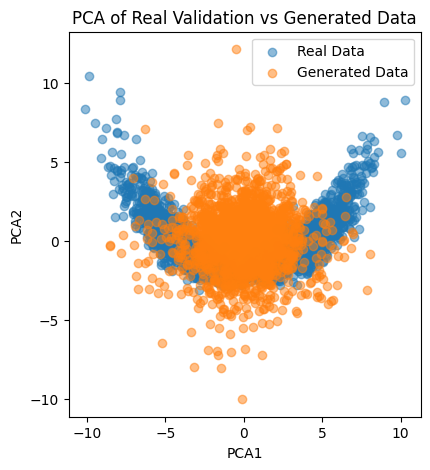

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cuml.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Reduce dimensionality with PCA 
pca = PCA(n_components=2)
pca_real_val_data = pca.fit_transform(scaled_real_val_data)
pca_generated_data_allzm_20 = pca.fit_transform(combined_generated_data_allzm_20)

import matplotlib.pyplot as plt
%matplotlib inline
# Plot PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_real_val_data.iloc[:, 0], pca_real_val_data.iloc[:, 1], label='Real Data', alpha=0.5)
plt.scatter(-pca_generated_data_allzm_20.iloc[:, 0], -pca_generated_data_allzm_20.iloc[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA of Real Validation vs Generated Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

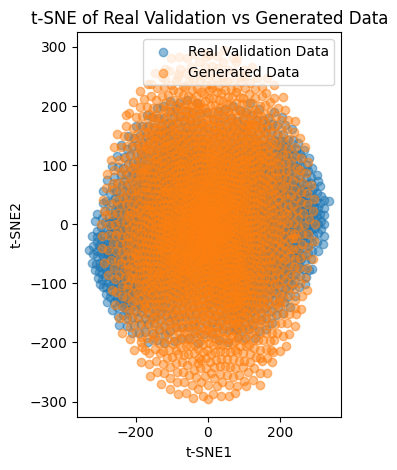

In [74]:
# Reduce dimensionality with t-SNE
from cuml.manifold import TSNE #from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, method='barnes_hut')
tsne_real_val_data = tsne.fit_transform(scaled_real_val_data)
tsne_generated_data_all_20 = tsne.fit_transform(combined_generated_data_allzm_20)

# Plot t-SNE results
plt.subplot(1, 2, 2)
for dataset, label in zip([tsne_real_val_data, tsne_generated_data_all_20], ['Real Validation Data', 'Generated Data']):
    plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], label=label, alpha=0.5)
plt.title('t-SNE of Real Validation vs Generated Data')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()

plt.tight_layout()
plt.show()

Note: This code was originally adapted from the implementation by Saatchai and Wilson in Tensorflow (https://github.com/andrewgordonwilson/bayesgan) and the DCGAN code from Pytorch examples (https://github.com/pytorch/examples/tree/master/dcgan).
I adapted that code from ben_athiwaratkun/pytorch-bayesgan.